# Дипломна работа. Препоръчване на продукти в интерактивна среда чрез машинно самообучение

## Николай Станчев, Изкуствен интелект, ф.н 8MI3400153
***

Програмната реализация и експерименти към дипломната работа се състоят от следните части:

1. Имплементация и сравнение на базови модели от тип "многорък бандит"

2. Имплементация на LinUCB алгоритъма

3. Експерименти с имплементация на LinUCB с цел препоръчване на филми

***

## 1. Имплементация и сравнение на базови модели от тип "многорък бандит"

Рамката на моделите от тип "многорък бандит" е представена с диаграма долу. Най-популярният пример е за хазартен играч, който играе в казино на ред с няколко слот машини. В диаграмата по-долу играча представлява агентът, който на всяка времева стъпка $t$ избира на коя слот машина да играе. След всеки избор средата (слот машината) предоставя печалба $R_t$. Наблюдаваната печалба дава възможност на агента да има повече информация за средата, който използва информацията, за да постигне основната си цел - постигане на възможно най-голяма печалба.

Mounted at /content/drive


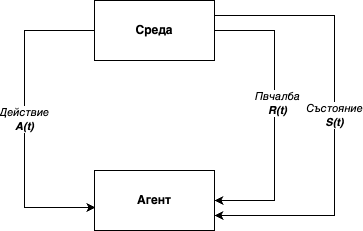

In [1]:
from google.colab import drive
drive.mount('/content/drive') # todo: remove
from IPython.display import Image
Image(filename='drive/MyDrive/diagram.png')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse.linalg import svds
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import time
np.random.seed(42)

### 1. Модел от тип "многорък бандит" с произволен избор на ръка

С цел сравнение, ще реализираме модел работещ на принципа на "бандитските" модели, но с произволна стратегия. Вместо да избира най-добрата ръка, изборът се прави на произволен принцип

In [ ]:
def random_bandit(arms, T_max, sigma):

    K = len(arms) # number of arms
    estimation = [0]*K  # we set the estimates for the arms to 0 as we don't have any info yet

    for i in range(K):
        estimation[i] = np.random.normal(arms[i], sigma) # we pull each arm once

    N = [1]*K # track how many times an arm is pulled
    R = [0] # global regret initialized to 0
    best = np.max(arms) # best arm

    for t in range(T_max): # main loop

        pull_i = np.random.randint(K) # we pull an arm randomly

        reward = np.random.normal(arms[pull_i], sigma)
        estimation[pull_i] = (estimation[pull_i]*N[pull_i] + reward)/(N[pull_i]+1) # update of the estimate for the pulled arm

        N[pull_i] += 1 # update of number of pulled times
        R.append(R[-1] + (best - arms[pull_i])) # regret update

    return R, (np.argmax(arms) == np.argmax(estimation))

Открита ли е ръката с най-голяма печалба ? Да
Финална пропусната печалба : 20143


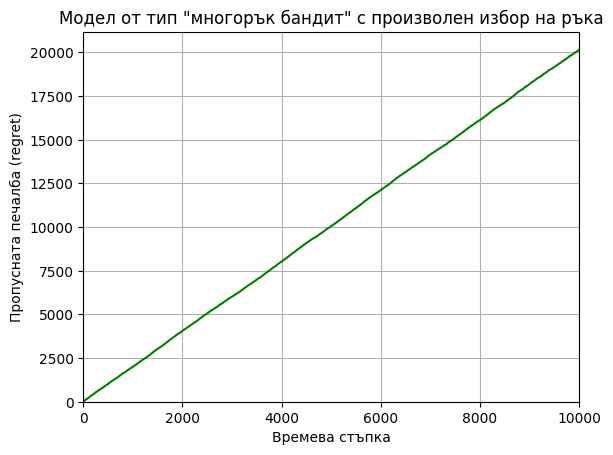

In [ ]:
arms  = [1, 2, 3, 4, 5] # list of arm
T_max = 10000 # max time step
sigma = 0.5

R_random, optimal_arm_found = random_bandit(arms, T_max, sigma)

print("Открита ли е ръката с най-голяма печалба ?", ("Да" if optimal_arm_found else "Не"))
print("Финална пропусната печалба :",R_random[-1])

plt.style.use('default')
plt.plot(R_random, color='green')
plt.xlim(0,T_max)
plt.xlabel("Времева стъпка")
plt.ylabel("Пропусната печалба (regret)")
plt.title("Модел от тип \"многорък бандит\" с произволен избор на ръка")
plt.ylim(0)
plt.grid()
plt.show()

Очаквано, поради произволният избор, развието на пропусната печалба е линейна, което означава че алгоритъмът не научава най-добрата ръка

### 2. Модел от тип "многорък бандит" с епсилон алчна стратегия

Степента на изследване (срещу експлоатиране) се задава с $\epsilon$. $\epsilon$ може да е фиксирано, а също така и да зависи от друг параметър например времевата стъпка t. По-долу ще разгледаме две имплементации, при които $\epsilon$ = $\dfrac{\alpha}{t}$ и $\epsilon$ = $\dfrac{\alpha}{\sqrt t}$


In [ ]:
def e_greedy_bandit(arms, T_max, sigma, alpha, root=False):

    K = len(arms) # number of arms
    estimation = [0]*K # we set the estimates for the arms to 0 as we don't have any info yet.

    for i in range(K):
        estimation[i] = np.random.normal(arms[i], sigma) # initialization

    N = [1]*K # track how many times an arm is pulled
    R = [0] # global regret initialized to 0
    best = np.max(arms) # best arm

    for t in range(T_max):

        if root: # choice of epsilon
            epsilon = alpha/np.sqrt(t + 1)
        else:
            epsilon = alpha/(t + 1)

        greed_factor = np.random.rand() # random sample from a uniform distribution over [0, 1]
        if greed_factor < epsilon:
            pull_i = np.random.randint(K) # exploration. draw an arm at random
        else:
            pull_i = np.argmax(estimation) # exploitation

        reward = np.random.normal(arms[pull_i], sigma)
        estimation[pull_i] = (estimation[pull_i]*N[pull_i] + reward)/(N[pull_i]+1) # estimate update

        N[pull_i] += 1 # update of number of pulled times
        R.append(R[-1] + (best - arms[pull_i])) # regret update

    return R, (np.argmax(arms) == np.argmax(estimation))

Открита ли е ръката с най-голяма печалба ? Да
Финална пропусната печалба : 74.9


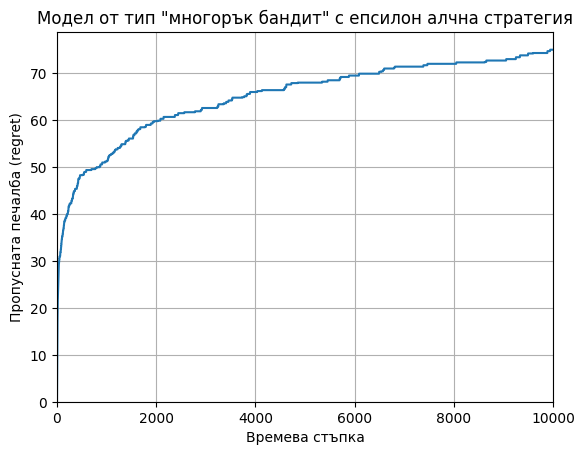

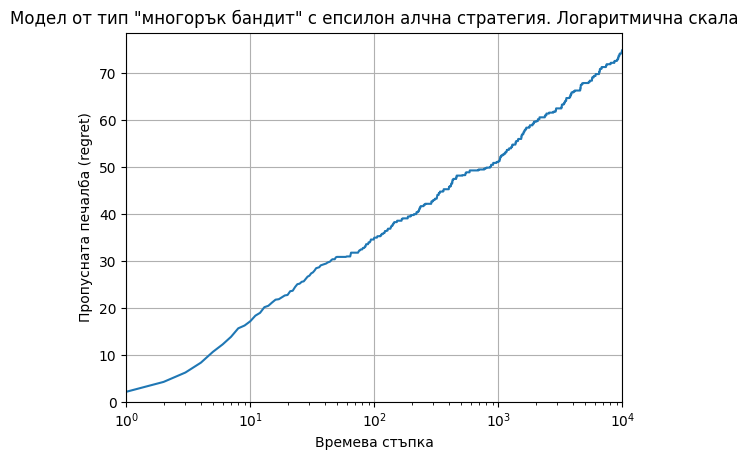

In [ ]:
# Epsilon / t
arms  = [1,2,3,4,5]
T_max = 10000
sigma = 1
alpha = np.sqrt(2*np.log(T_max))  # based on Hoeffding equality

# We average the results
R_eps1 = [0]*T_max
for _ in range(10):
    R_r, optimal_arm_found = e_greedy_bandit(arms, T_max, sigma, alpha)
    for i in range(T_max):
        R_eps1[i] += R_r[i]
for i in range(T_max):
    R_eps1[i] /= 10


print("Открита ли е ръката с най-голяма печалба ?", ("Да" if optimal_arm_found else "Не"))
print("Финална пропусната печалба :",R_eps1[-1])

plt.plot(R_eps1)
plt.xlim(0,T_max)
plt.xlabel("Времева стъпка")
plt.ylabel("Пропусната печалба (regret)")
plt.title("Модел от тип \"многорък бандит\" с епсилон алчна стратегия")
plt.ylim(0)
plt.grid()
plt.show()

plt.plot(R_eps1)
plt.xlim(1,T_max)
plt.xscale("log")
plt.xlabel("Времева стъпка")
plt.ylabel("Пропусната печалба (regret)")
plt.title("Модел от тип \"многорък бандит\" с епсилон алчна стратегия. Логаритмична скала")
plt.ylim(0)
plt.grid()
plt.show()

Резултатът е класическа крива на пропусната печалба, която се увеличава с бързи темпове в началото, понеже алгоритъмът изследва по-често и избира неоптимална ръка. Изследването обаче и помага да се коригира и в крайна сметка да избира най-оптималната ръка.

Открита ли е ръката с най-голяма печалба ? Да
Финална пропусната печалба : 1660.0


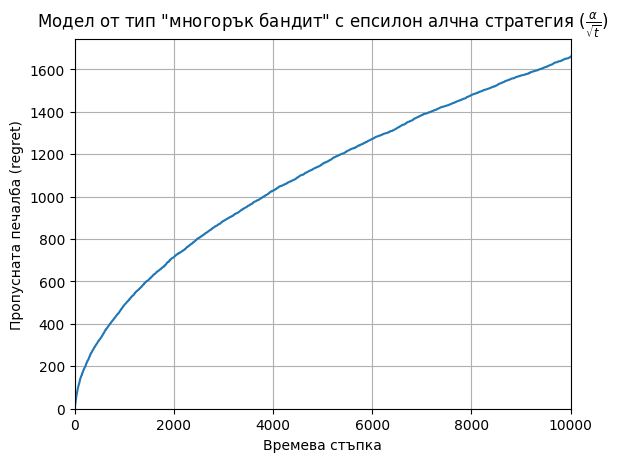

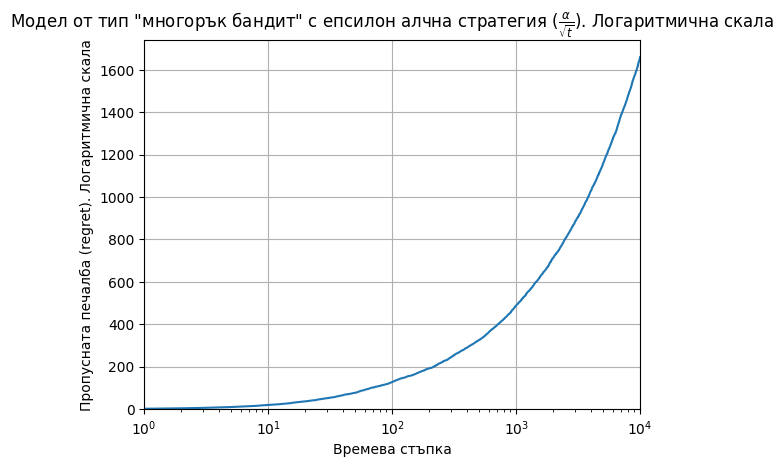

In [ ]:
# Epsilon / sqrt(t)
arms  = [1,2,3,4,5]
T_max = 10000
sigma = 1
alpha = np.sqrt(2*np.log(T_max)) # based on Hoeffding equality

R_eps2 = [0]*T_max
for _ in range(10):
    R_r, optimal_arm_found = e_greedy_bandit(arms, T_max, sigma, alpha, True)
    for i in range(T_max):
        R_eps2[i] += R_r[i]
for i in range(T_max):
    R_eps2[i] /= 10


print("Открита ли е ръката с най-голяма печалба ?", ("Да" if optimal_arm_found else "Не"))
print("Финална пропусната печалба :",R_eps2[-1])

plt.plot(R_eps2)
plt.xlim(0,T_max)
plt.xlabel("Времева стъпка")
plt.ylabel("Пропусната печалба (regret)")
plt.title(r"""Модел от тип "многорък бандит" с епсилон алчна стратегия ($\frac{\alpha}{\sqrt{t}}$)""")
plt.ylim(0)
plt.grid()
plt.show()

plt.plot(R_eps2)
plt.xlim(1,T_max)
plt.xscale("log")
plt.xlabel("Времева стъпка")
plt.ylabel("Пропусната печалба (regret). Логаритмична скала")
plt.title(r"""Модел от тип "многорък бандит" с епсилон алчна стратегия ($\frac{\alpha}{\sqrt{t}}$). Логаритмична скала""")
plt.ylim(0)
plt.grid()
plt.show()

В този вариант $\epsilon$ намалява по-бавно с времевите стъпки, което означава че алгоритъма залага повече на изследване отколкото на експлоатиране. Това обаче води до увеличение в пропуснатата печалба в тази симулация

### 3. Модел от тип "многорък бандит" с горна доверителна граница (UCB)

При тази стратегия се използва статистически доверителни интервали за вземане на решения, като така се гарантира, че изборът се основава не само на минали печалби, но и на несигурността около тези печалби. UCB работи на проста предпоставка: ако дадена опция (или „ръка“) не е изследвана много, тя може да има потенциал и системата трябва да бъде оптимистична за това.

Този оптимизъм се определя количествено чрез конструиране на горна граница на очакваната печалба за всяка ръка и се избира ръката с най-висока горна граница
С времето несигурността относно ръцете намалява и алгоритъма успешно идентифицира оптималната ръка.

In [ ]:
def UCB_bandit(arms, T_max, sigma, alpha):

    K = len(arms) # number of arms
    estimation = [0]*K # we set the estimates for the arms to 0

    for i in range(K):
        estimation[i] = np.random.normal(arms[i], sigma) # initialization

    N = [1]*K # track how many times an arm is pulled
    R = [0] # global regret initialized to 0
    best = np.max(arms) # best arm

    for t in range(T_max):

        pull_i = np.argmax([estimation[i] + alpha/np.sqrt(N[i]) for i in range(K)]) # we pull the arm with the greatest uncertainty on the estimation of its reward

        reward = np.random.normal(arms[pull_i], sigma) # observe reward
        estimation[pull_i] = (estimation[pull_i]*N[pull_i] + reward)/(N[pull_i]+1) # estimate update

        N[pull_i] += 1 # update of activation number
        R.append(R[-1] + (best - arms[pull_i])) # regret update

    return R,(np.argmax(arms) == np.argmax(estimation))

Открита ли е ръката с най-голяма печалба ? Да
Финална пропусната печалба : 0.06873361376323678


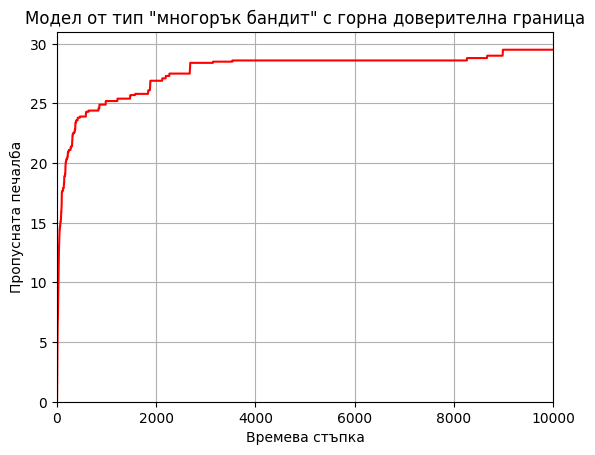

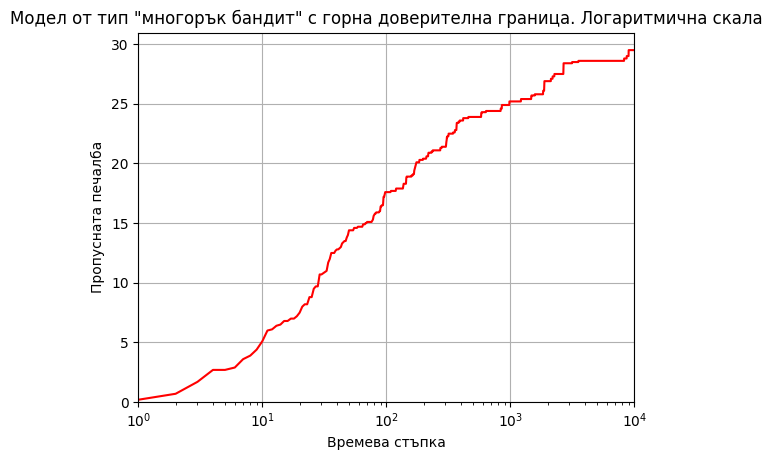

In [ ]:
arms  = [1,2,3,4,5]
T_max = 10000
sigma = 1
alpha = np.sqrt(2*np.log(T_max))

R_UCB1 = [0]*T_max
for _ in range(10):
    R_r, success = UCB_bandit(arms, T_max, sigma, alpha)
    for i in range(T_max):
        R_UCB1[i] += R_r[i]

for i in range(T_max):
    R_UCB1[i] /= 10

print("Открита ли е ръката с най-голяма печалба ?", ("Да" if optimal_arm_found else "Не"))
print("Финална пропусната печалба :",R_UCB1[-1]/(alpha*np.sqrt(T_max)))

plt.plot(R_UCB1, color='red')
plt.xlim(0,T_max)
plt.xlabel("Времева стъпка")
plt.ylabel("Пропусната печалба")
plt.title("Модел от тип \"многорък бандит\" с горна доверителна граница")
plt.ylim(0)
plt.grid()
plt.show()

plt.plot(R_UCB1, color='red')
plt.xlim(1,T_max)
plt.xscale('log')
plt.xlabel("Времева стъпка")
plt.ylabel("Пропусната печалба")
plt.title("Модел от тип \"многорък бандит\" с горна доверителна граница. Логаритмична скала")
plt.ylim(0)
plt.grid()
plt.show()

От графиките става ясно, че от всички симулации досега, достигаме най-бързо до оптималната ръка чрез UCB стратегията

### 4. Съпоставяне на представянето на моделите

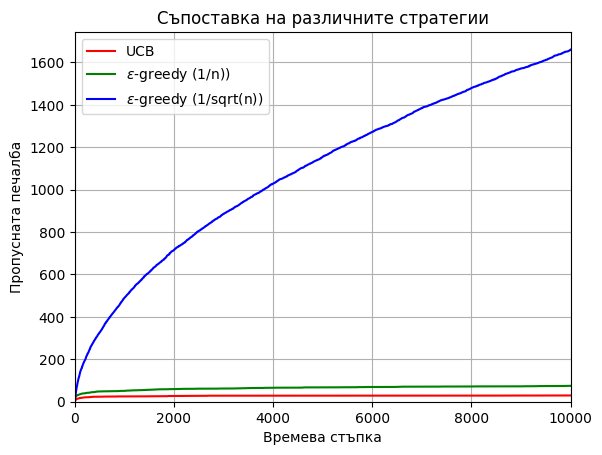

In [ ]:
plt.plot(R_UCB1,label="UCB", color='red')
plt.plot(R_eps1,label=r"$\epsilon$-greedy (1/n))", color='green')
plt.plot(R_eps2,label=r"$\epsilon$-greedy (1/sqrt(n))", color='blue')

plt.xlim(0,T_max)
plt.xlabel("Времева стъпка")
plt.ylabel("Пропусната печалба")
plt.title("Съпоставка на различните стратегии")
plt.ylim(0)
plt.legend()
plt.grid()
plt.show()

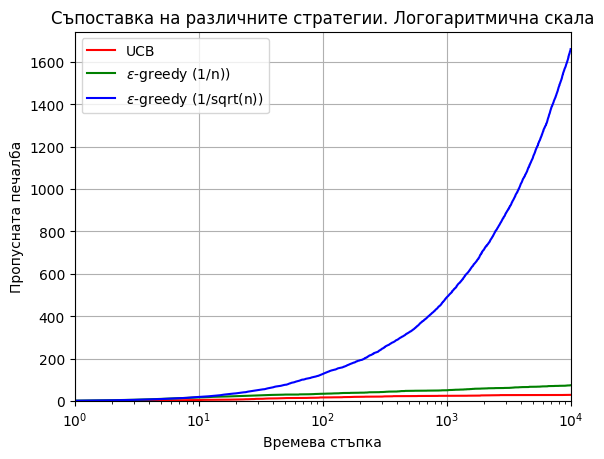

In [ ]:
plt.plot(R_UCB1,label="UCB", color='red')
plt.plot(R_eps1,label=r"$\epsilon$-greedy (1/n))", color='green')
plt.plot(R_eps2,label=r"$\epsilon$-greedy (1/sqrt(n))", color='blue')

plt.xlim(1,T_max)
plt.xscale('log')
plt.xlabel("Времева стъпка")
plt.ylabel("Пропусната печалба")
plt.title("Съпоставка на различните стратегии. Логогаритмична скала")
plt.ylim(0)
plt.legend()
plt.grid()
plt.show()

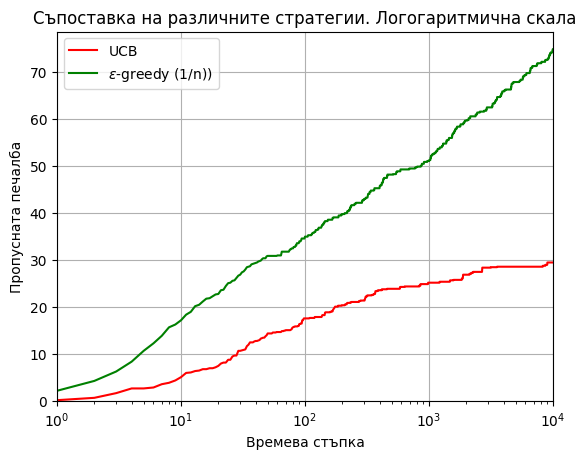

In [ ]:
plt.plot(R_UCB1,label="UCB", color='red')
plt.plot(R_eps1,label=r"$\epsilon$-greedy (1/n))", color='green')

plt.xlim(1,T_max)
plt.xscale('log')
plt.xlabel("Времева стъпка")
plt.ylabel("Пропусната печалба")
plt.title("Съпоставка на различните стратегии. Логогаритмична скала")
plt.ylim(0)
plt.legend()
plt.grid()
plt.show()

Забелязваме, че пропусната печалба, постигната чрез UCB е значително по-малко от епсилон алчната стратегия. Поради тази причина в останалата част от дипломната работа ще се фокусираме върху контекстуалният вариант на UCB в контекста на препоръчване на филми.

Но преди това нека разгледаме какво се случва с пропуснатата печалба при различни стойности за хипер параметрите на UCB модела.

###5. Изследване на хипер параметри за UCB стратегията

Нека разгледаме чувствителността на модела спрямо броя "ръце"

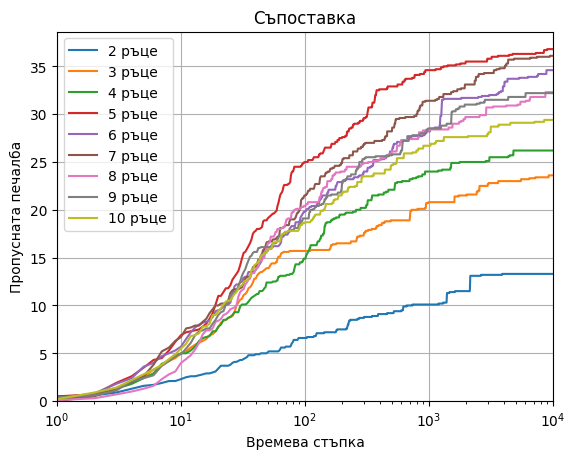

In [ ]:
select_arms = [2, 3, 4, 5, 6, 7, 8, 9, 10]
arms  = [k+1 for k in range(np.max(select_arms))]
T_max = 10000
sigma = 1
alpha = np.sqrt(2*np.log(T_max))

R_UCB1_sensiitvity = [[0] * T_max for i in range(len(arms))]
R_temp = [0]*T_max
for i in range(len(select_arms)):
    for _ in range(10):
        R_temp, sucess = UCB_bandit(arms[:select_arms[i]], T_max, sigma, alpha)
        for j in range(T_max):
            R_UCB1_sensiitvity[i][j] += R_temp[j]

    for k in range(T_max):
        R_UCB1_sensiitvity[i][k] /= 10

    plt.plot(R_UCB1_sensiitvity[i], label='%s ръце' % select_arms[i])

plt.xlim(1,T_max)
plt.xscale('log')
plt.xlabel("Времева стъпка")
plt.ylabel("Пропусната печалба")
plt.title(r"Съпоставка")
plt.ylim(0)
plt.legend()
plt.grid()
plt.show()

Забелязваме, че очаквано стойностите за пропусната печалба се повишават с повишаването на броя на ръцете, но графиките и съответно темповете на понижение са сходни.

Нека разгледаме чувствителността на модела спрямо стандартното отклонение $\sigma$, което от една страна се използва за задаване на нормалното разпределение при иницииране на очакванията за ръцете на модела. А от друга, като параметър за шум при наблюдаване на печалбите в процеса на работа на алгоритъма

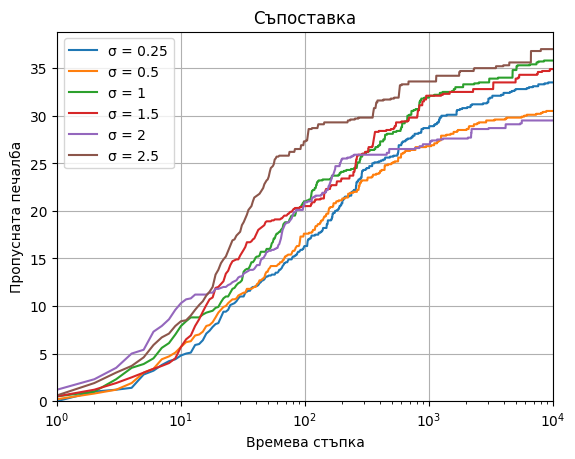

In [ ]:
arms  = [1, 2, 3, 4, 5]
T_max = 10000
sigma = [0.25, 0.5, 1, 1.5, 2, 2.5]
alpha = np.sqrt(2*np.log(T_max))

R_UCB1_sensitivity_2 = [[0] * T_max for i in range(len(sigma))]
R_temp = [0]*T_max
for i in range(len(sigma)):
    for _ in range(10):
        R_temp, sucess = UCB_bandit(arms, T_max, sigma[i], alpha)
        for j in range(T_max):
            R_UCB1_sensitivity_2[i][j] += R_temp[j]

    for k in range(T_max):
        R_UCB1_sensitivity_2[i][k] /= 10

    plt.plot(R_UCB1_sensitivity_2[i], label='\u03C3 = %s' % sigma[i])

plt.xlim(1,T_max)
plt.xscale('log')
plt.xlabel("Времева стъпка")
plt.ylabel("Пропусната печалба")
plt.title(r"Съпоставка")
plt.ylim(0)
plt.legend()
plt.grid()
plt.show()

## 2. Имплементация на LinUCB

По-долу са представени имплементации на два варианта на LinUCB разновидността на "многорък бандит". Вдъхновени са от научната статия [*A Contextual-Bandit Approach to Personalized News Article Recommendation*](http://rob.schapire.net/papers/www10.pdf), Li et al.*

Разликата спрямо стандартният UCB подход се състои в това, че очакваната печалба не е просто числова стойност, която трябва да се предскаже, а вече се моделира като функция на контекста на потребителя. По-конкретно в случая, това е линейната функция $r_{t,a}$ (където $a$ е индекса на дадена ръка, а $t$ времевата стъпка): $E [r_{t,a}|x_{t,a}] = {x_{t,a}}^T {\theta_a}^*$. Стойността и се задава от скаларното произведение на контекстният вектор $x_{t,a}$ (в случая това са признаците на филмите за времева стъпка t) и вектора с признаци, които модела се опитва да научи за всяка ръка (филм) спрямо определен потребител. Моделът се нарича disjoint (в превод от английски несвързан), тъй като тегловният вектор не е споделен между всички ръце, а е отделен за всяка

За целта ще изпозлваме добре познатият дейтасет MovieLens. По-конректно варианта му с 1 милион оценки. За да извлечем признаците за филмите, а в последствие и потребителите ще използваме декомпозиране по сингулярни стойности(SVD) на матрица състояща се от колони за потребител, филм и оценка на потребител за филм.


In [ ]:
ratings = pd.read_csv('drive/MyDrive/ml-1m/ratings.dat', sep='::',
                        names = ['UserID', 'MovieID', 'Rating', 'Timestamp'],
                        encoding = 'latin1',
                        engine = 'python')
movies  = pd.read_csv('drive/MyDrive/ml-1m/movies.dat',  sep='::',
                        names = ['MovieID', 'Title', 'Genres'],
                        encoding = 'latin1',
                        engine ='python')
users   = pd.read_csv('drive/MyDrive/ml-1m/users.dat',  sep='::',
                        names = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip'],
                        encoding = 'latin1',
                        engine = 'python')

# Films with sufficient numbers of reviews
N = 1000
ratings_count = ratings.groupby(by='MovieID', as_index=True).size()
top_ratings = ratings_count[ratings_count>=N]
top_ratings.head(10)


ratings_topN = ratings[ratings.MovieID.isin(top_ratings.index)]

n_users = ratings_topN.UserID.unique().shape[0]
n_movies = ratings_topN.MovieID.unique().shape[0]

# Low rank matrix factorization
R_df = ratings_topN.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)

M = R_df.values
sparsity=round(1.0-np.count_nonzero(M)/float(n_users*n_movies),3)

# Sparse SVD with K = 30 features
K = 30
U, s, Vt = svds(M, k = K)
s=np.diag(s)
U = np.dot(U,s)

#### 2.1 Вариант 1 - LinUCB Disjoint

In [ ]:
def LinUCB_disjoint(Vt, U, user, alpha, sigma, lambd, T_max, best_score=0):
    (n, d) = U.shape # d - number of user features
    (_, m) = Vt.shape # m - number of arms

    # init
    A = np.zeros((m, d, d))
    b = np.zeros((m, d))
    x_a = np.zeros(d) # context vector
    theta_search = np.zeros((m, d))
    payoff = np.zeros(m)
    upper = 0
    chosen_arm = 0
    reward = np.zeros(T_max)
    regret = [0]

    # initialization for each arm
    for a in range(m):
        A[a] = lambd*np.identity(d)
        b[a] = 0

    # reward initialization for each arm
    for a in range(m):
        x_a = Vt.T[a]
        inv_A = np.linalg.inv(A[a])
        theta_search[a] = inv_A.dot(b[a])
        upper = x_a.T.dot(inv_A).dot(x_a)
        payoff[a] = theta_search[a].T.dot(x_a) + alpha * np.sqrt(upper) # UCB

    for t in range(T_max):
        # film number chosen; random selection if same payoff for several films
        chosen_arm = np.random.choice(np.argwhere(payoff == np.amax(payoff)).T[0])

        x_chosen = Vt.T[chosen_arm] # features of chosen film

        # reward with added Gaussian noise to simulate possible errors
        reward[t] = U[user].dot(x_chosen) + np.random.normal(0,sigma)  #  observe reward
        regret.append(regret[-1] + best_score - U[user].dot(x_chosen)) #  regret update

        A[chosen_arm] += np.outer(x_chosen, x_chosen.T)
        b[chosen_arm] += reward[t] * x_chosen

        inv_A = np.linalg.inv(A[chosen_arm])
        theta_search[chosen_arm] = inv_A.dot(b[chosen_arm])
        upper = x_chosen.T.dot(inv_A).dot(x_chosen)

        # We update the estimate of the reward for the arm that was drawn
        payoff[chosen_arm] = theta_search[chosen_arm].T.dot(x_chosen) + alpha * np.sqrt(upper)

    best_arm = np.argmax([theta_search[a].T.dot(Vt.T[a]) for a in range(m)])
    return reward, best_arm, regret

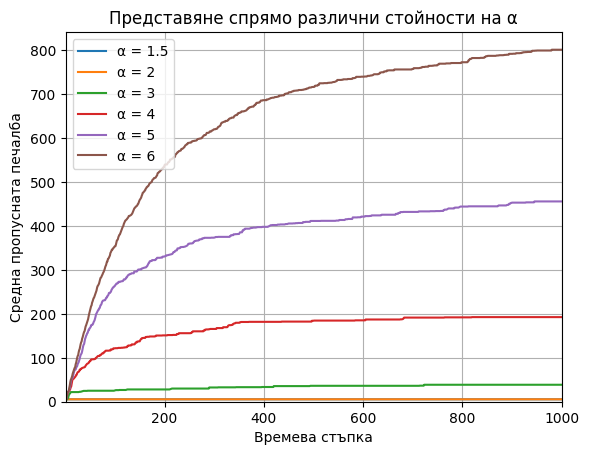

In [ ]:
# hyperparameter alpha - controls exploration vs exploation through confidence interval
T_max = 1000
alpha = [1.5, 2, 3, 4, 5, 6]
sigma = 0.5
lambd = 0.1
r = np.random.randint(len(U))

best_score = np.max([U[r].dot(Vt.T[i]) for i in range(207)])

avg_regret_sensibility = [[0] * T_max for i in range(len(alpha))]
for i in range(len(alpha)):
    for _ in range(3):
        reward, chosen_arm, regret = LinUCB_disjoint(Vt, U, r,  alpha[i], sigma, lambd, T_max, best_score=best_score)
        for j in range(T_max):
            avg_regret_sensibility[i][j] += regret[j]
    for k in range(T_max):
        avg_regret_sensibility[i][k] /= 3

    plt.plot(avg_regret_sensibility[i], label='\u03B1 = %s' % alpha[i])

plt.xlim(1,T_max)
#plt.xscale('log')
plt.xlabel("Времева стъпка")
plt.ylabel("Средна пропусната печалба")
plt.title("Представяне спрямо различни стойности на \u03B1")
plt.ylim(0)
plt.legend()
plt.grid()
plt.show()

За по-ниски нива на $\alpha$ се наблюдава по-ниска средна пропусната печалба.

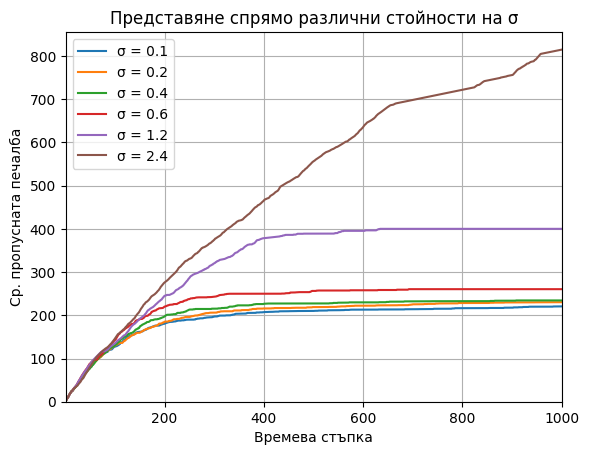

In [ ]:
# hyper parameter sigma
T_max = 1000
alpha = 2
sigma = [0.1, 0.2, 0.4, 0.6, 1.2, 2.4]
lambd = 0.1
# r = np.random.randint(len(U))
r = 3007
best_score = np.max([U[r].dot(Vt.T[i]) for i in range(207)])

avg_regret_sensibility2 = [[0] * T_max for i in range(len(sigma))]
for i in range(len(sigma)):
    for _ in range(3):
        reward, chosen_arm, regret = LinUCB_disjoint(Vt, U, r,  alpha, sigma[i], lambd, T_max, best_score=best_score)
        for j in range(T_max):
            avg_regret_sensibility2[i][j] += regret[j]
    for k in range(T_max):
        avg_regret_sensibility2[i][k] /= 3

    plt.plot(avg_regret_sensibility2[i], label='\u03C3 = %s' % sigma[i])

plt.xlim(1,T_max)
#plt.xscale('log')
plt.xlabel("Времева стъпка")
plt.ylabel("Ср. пропусната печалба")
plt.title("Представяне спрямо различни стойности на \u03C3")
plt.ylim(0)
plt.legend()
plt.grid()
plt.show()

От графиката се вижда, че при по-ниски стойности на $\sigma$ получаваме по-ниска средна пропусната печалба. Това в общият случай изглежда логично, тъй като този хипер параметър отговаря за количеството симулиран шум в наблюдаваната печалба

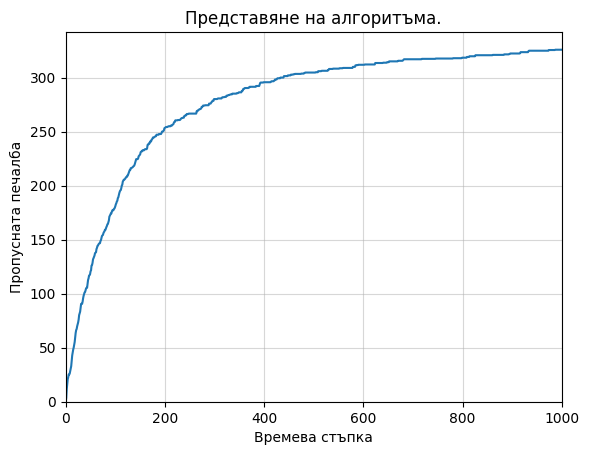

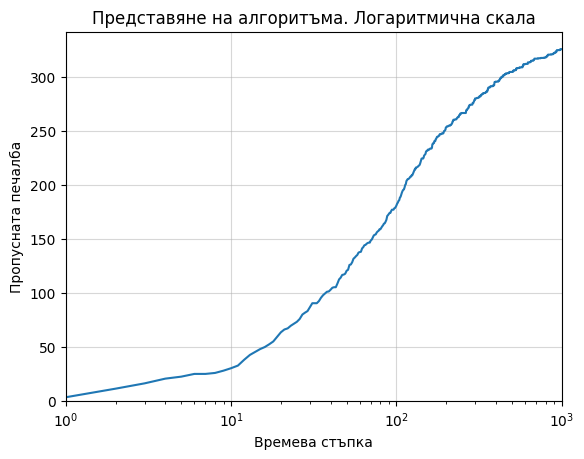

In [ ]:
# Hyper params
T_max = 1000
alpha = 5.5
sigma = 0.5
lambd = 0.1
r_user = np.random.randint(len(U)) # We select a user at random.

best_score = np.max([U[r_user].dot(Vt.T[i]) for i in range(207)])

# Average regret
avg_regret1 = [0]*T_max
for _ in range(5):
    reward, chosen_arm, regret = LinUCB_disjoint(Vt, U, r_user,  alpha, sigma, lambd, T_max, best_score=best_score)
    for i in range(T_max):
        avg_regret1[i] += regret[i]

for i in range(T_max):
    avg_regret1[i] /= 5

### Plots
plt.plot(avg_regret1)
plt.xlim(0,T_max)
plt.xlabel("Времева стъпка")
plt.ylabel("Пропусната печалба")
plt.title("Представяне на алгоритъма.")
plt.ylim(0)
plt.grid(alpha=0.5)
plt.show()

plt.plot(avg_regret1)
plt.xlim(1,T_max)
plt.xscale("log")
plt.xlabel("Времева стъпка")
plt.ylabel("Пропусната печалба")
plt.title("Представяне на алгоритъма. Логаритмична скала")
plt.ylim(0)
plt.grid(alpha=0.5)
plt.show()

Резултатът е обнадеждаващ, от гледна точка на това, че алгоритъма се научава да избира най-добрият филм. Разбира се, към момента това не е никак реалистично понеже се налага да препоръчаме 1000 пъти филми на потребителя преди да сме сигурни, че препоръчаният е най-предпочитаният.

Нека видим точността за произволна извадка потребители (100 на брой) и времето което отнема

In [ ]:
T_max = 1000
alpha = 5.5
sigma = 0.5
lambd = 0.1

maxlen = len(U)
count = 0

rTab = np.random.choice([i for i in range(len(U))],100,replace=False)

t_start = time.time()
for u in range(100):
    r = rTab[u]
    #print(r,":",1+u,"/100")
    best = np.argmax([U[r].dot(Vt.T[i]) for i in range(207)])
    reward, chosen_arm, regret = LinUCB_disjoint(Vt, U, r,  alpha, sigma, lambd, T_max)
    if chosen_arm == best:
        count += 1

t_end = time.time()
print("Точност : ",count,"%")
print("Време за един потребител: ",(t_end-t_start)/100,"s")

Accuracy :  97 %
Time / user :  0.3996769142150879 s


#### 2.2  LinUCB хибридна версия

Ще имплементираме и хибридната версия, представена в научната статия от *Li et Al* спомената по-горе. Разликата при нея е че към изчисленията на вектор $\theta_a$ за всеки филм $a$ ще добавим и контекстен вектор $\beta^*$ в който се пазят линейните коефициенти, свързани със споделените между всички филми признаци (features). Така $\beta^*$ се използва за да определи отделните коефициенти на всяка ръка, представени чрез вектор $\theta_a*$

In [ ]:
def HybridLinUCB(Vt, U, user, alpha, sigma, lambd, T_max, best_score=0):
    (n, d) = U.shape # d : number of features
    (_, m) = Vt.shape # m :number of arms
    k = d*d # number of common features

    A0 = np.identity(k)
    b0 = np.zeros(k)

    A = np.zeros((m, d, d))
    B = np.zeros((m, d, k))
    b = np.zeros((m, d))
    x_a = np.zeros(d) # context vector
    z_a = np.zeros(k) # common feature vector for a movie/user

    theta_search = np.zeros((m, d))
    payoff = np.zeros(m)
    upper = 0
    chosen_arm = 0
    reward = np.zeros(T_max)
    regret = [0]

    inv_A0 = np.linalg.inv(A0)

    beta_search = inv_A0.dot(b0)

    for a in range(m):
        A[a] = lambd*np.identity(d)
        B[a] = np.zeros(k)
        b[a] = np.zeros(d)

    # For each film
    for a in range(m):
        x_a = Vt.T[a,]
        z_a = np.outer(Vt.T[a,],U[user,]).flatten()

        inv_A = np.linalg.inv(A[a])

        theta_search[a] = inv_A.dot(b[a]-B[a].dot(beta_search))

        upper = z_a.T.dot(inv_A0).dot(z_a) - 2*z_a.T.dot(inv_A0).dot(B[a].T).dot(inv_A).dot(x_a) + x_a.T.dot(inv_A).dot(x_a) + x_a.T.dot(inv_A).dot(B[a]).dot(inv_A0).dot(B[a].T).dot(inv_A).dot(x_a)
        payoff[a] = (z_a.T).dot(beta_search) + x_a.T.dot(theta_search[a]) + alpha * np.sqrt(upper)

    for t in range(T_max):
        chosen_arm = np.random.choice(np.argwhere(payoff == np.amax(payoff)).T[0])
        x_chosen = Vt.T[chosen_arm]
        z_chosen =  np.outer(Vt.T[chosen_arm],U[user,]).flatten()

        reward[t] = U[user].dot(x_chosen) + np.random.normal(0,sigma)
        regret.append(regret[-1] + best_score - U[user].dot(x_chosen))

        inv_A = np.linalg.inv(A[chosen_arm])

        A0 += (B[chosen_arm].T).dot(inv_A).dot(B[chosen_arm])
        b0 += (B[chosen_arm].T).dot(inv_A).dot(b[chosen_arm])

        A[chosen_arm] += np.outer(x_chosen, x_chosen.T)
        B[chosen_arm] += np.outer(x_chosen, z_chosen.T)
        b[chosen_arm] += reward[t] * x_chosen

        # Update of A[chosen_arm], thus update of its inverse
        inv_A = np.linalg.inv(A[chosen_arm])

        A0 += np.outer(z_chosen,z_chosen.T) - (B[chosen_arm].T).dot(inv_A).dot(B[chosen_arm])
        b0 += reward[t]*z_chosen - (B[chosen_arm].T).dot(inv_A).dot(b[chosen_arm])

        theta_search[chosen_arm] = inv_A.dot(b[chosen_arm]-B[chosen_arm].dot(beta_search))
        upper = z_chosen.T.dot(inv_A0).dot(z_chosen) - 2*z_chosen.T.dot(inv_A0).dot(B[chosen_arm].T).dot(inv_A).dot(x_chosen) + x_chosen.T.dot(inv_A).dot(x_chosen) + x_chosen.T.dot(inv_A).dot(B[chosen_arm]).dot(inv_A0).dot(B[chosen_arm].T).dot(inv_A).dot(x_chosen)

        payoff[chosen_arm] = (z_chosen.T).dot(beta_search) + theta_search[chosen_arm].T.dot(x_chosen) + alpha * np.sqrt(upper)

    return reward, chosen_arm, regret

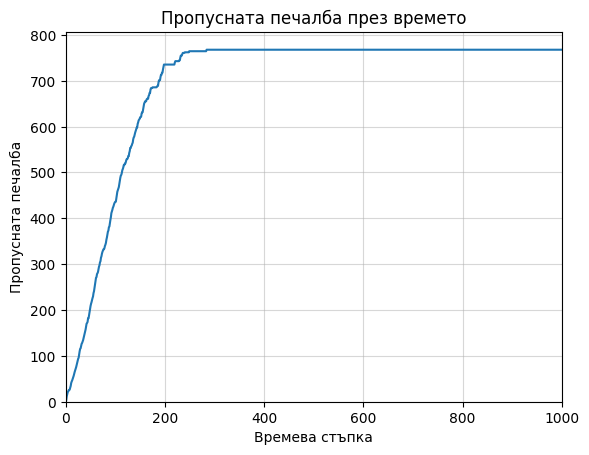

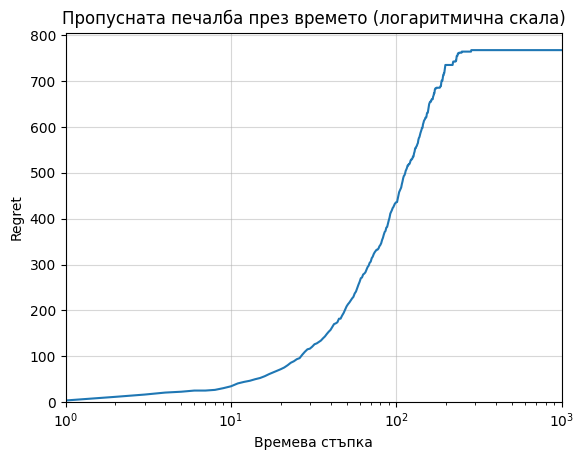

In [ ]:
# Hyper parameters
T_max = 1000
alpha = 0.5
sigma = 0.5
lambd = 0.3
best_score = np.max([U[r_user].dot(Vt.T[i]) for i in range(207)])

avg_regret_hybrid = [0]*T_max
for _ in range(1):
    reward, chosen_arm, regret = HybridLinUCB(Vt, U, r_user,  alpha, sigma, lambd, T_max, best_score=best_score)
    for i in range(T_max):
        avg_regret_hybrid[i] += regret[i]

for i in range(T_max):
    avg_regret_hybrid[i] /= 1

plt.plot(avg_regret_hybrid)
plt.xlim(0,T_max)
plt.xlabel("Времева стъпка")
plt.ylabel("Пропусната печалба")
plt.title("Пропусната печалба през времето")
plt.ylim(0)
plt.grid(alpha=0.5)
plt.show()

plt.plot(avg_regret_hybrid)
plt.xlim(1,T_max)
plt.xlabel("Времева стъпка")
plt.xscale("log")
plt.ylabel("Пропусната печалба")
plt.title("Пропусната печалба през времето (логаритмична скала)")
plt.ylim(0)
plt.grid(alpha=0.5)
plt.show()

От графиката се вижда, че **LinUCB хибридна версия** натрупва по-голяма пропусната печалба, но все пак в общия случай тя става константна.

## 3. Експерименти с имплементация на LinUCB с цел препоръчване на филми

В предходната част, стойността на точността за LinUCB, която постигнахме беше доста добра - 97% за около 0.4 секунди средно на потребител върху извадка от 100 произволно избрани потребители. Тази точност обаче не може да ни даде реалистична представа за представянето на алгоритъм в реална среда. Това което всъщност се измерва е процентното съотношение на потребители, чиито най-предпочитан филм е същият като този препоръчан от алгоритъма. Това обаче предполага няколко неща:

- Онлайн платформата предлагаща филмите (например Нетфликс) вече знае всички признаци на всички филми и не се предполага добавяне на нови
- Признаците на филмите са абсолютно точни
- Приемливо е да препоръчаме един и същ филми стотици пъти на потребител

Тъй като при предишният подход, поради разлагането на матрици на сингулярни(особени) стойности оценките за филми, които даден потребител не е гледан са 0. Предходните модели просто се научават да препоръчат на потребител филм, който те вече са оценили с най-високо оценка, като му го предлагат няколкото стотина пъти преди да са сигурни че са успели.

Следователно, е на лице нуждата от подобрения в модела, за да бъде по-удачен в реалистична среда. Крайната цел е следната:

- На времева стъпка $t= T_0$, препоръчващата система съдържа $n_0$ на брой потребители и $m_0$ на брой филми. Признаците на потребителите и филмите се използват в препоръчването.

- В последващи времеви стъпки $T_1,....,T_k$ да се позволява добавяне на нови потребители и филми. С всяко ново добавяне на потребител или филм, трябва да научим признаците на новия елемент от вече съществуващите.
- Предлагаме филми на потребители и се опитваме възможно най-бързо да можем да предскажем най-добрият и съответно да минимализираме пропуснатата печалба на модела.

Ще използваме само филми с поне 1000 оценки, ще използваме и само потребители с поне 20 изгледани от избраните филма.

In [3]:
ratings = pd.read_table('drive/MyDrive/ml-1m/ratings.dat', sep='::',
                        names = ['UserID', 'MovieID', 'Rating', 'Timestamp'],
                        encoding = 'latin1',
                        engine = 'python')
movies  = pd.read_table('drive/MyDrive/ml-1m/movies.dat',  sep='::',
                        names = ['MovieID', 'Title', 'Genres'],
                        encoding = 'latin1',
                        engine ='python')
users   = pd.read_table('drive/MyDrive/ml-1m/users.dat',  sep='::',
                        names = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip'],
                        encoding = 'latin1',
                        engine = 'python')

N = 1000 # Minimum number of ratings for a movie.
N2 = 20 # Minimum number of ratings for a user.

ratings_count = ratings.groupby(by='MovieID', as_index=True).size()
top_ratings = ratings_count[ratings_count>=N]
ratings_topN = ratings[ratings.MovieID.isin(top_ratings.index)]
ratings_count_user = ratings_topN.groupby(by="UserID",as_index=True).size()
top_ratings_user = ratings_count_user[ratings_count_user >= N2]
ratings_topNN2 = ratings_topN[ratings_topN.UserID.isin(top_ratings_user.index)] #Only the ratings we want are here

n_users = ratings_topNN2.UserID.unique().shape[0]
n_movies = ratings_topNN2.MovieID.unique().shape[0]
print('Брой потребители = {} | Брой филми = {}'.format(n_users, n_movies))

R_df = ratings_topNN2.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
M = R_df.values
(m1,m2) = M.shape

## Sparsity calculation
sparsity = round(1.0-np.count_nonzero(M)/float(n_users*n_movies),3)
print('Рядкост на матрицата = {}%'.format(sparsity*100))

## Extraction of features
K = 20 # number of features
U, s, Vt = svds(M, k = K)
s=np.diag(s)
U = np.dot(U,s)
(n,m) = U.shape[0],Vt.shape[1]
features_users = U
features_movies = Vt.T

Брой потребители = 4351 | Брой филми = 207
Рядкост на матрицата = 68.4%


Нека разгледаме разпредлението на брой филми изгледани от потребител

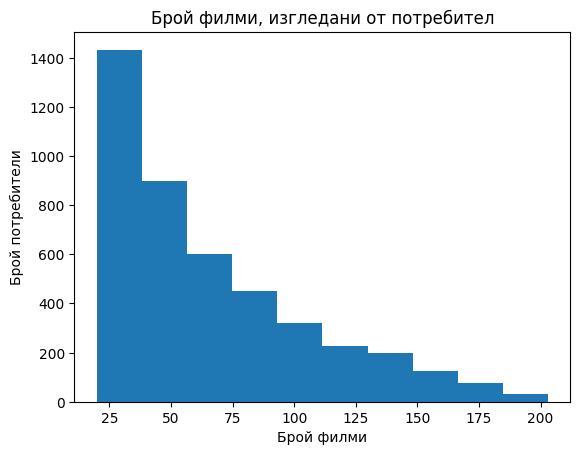

In [4]:
users_movies = []
for i in range(len(M)):
    count = 0
    for j in range(len(M[i])):
        if M[i][j] > 0:
            count += 1
    users_movies.append(count)

plt.xlabel("Брой филми")
plt.ylabel("Брой потребители")
plt.title("Брой филми, изгледани от потребител")
plt.hist(users_movies)
plt.show()

Алгоритъмът имплементиран по-долу представлява подобрение върху предходните в следните направления:

- Алгоритъма ще се ускори, ако транспонираме матрицата с очакванията за признаци на елемент не на всяка стъпка, а на няколко. Транспониране на всеки 5 не намалява с много точността, но значително намалява времето за изпълнение на алгоритъма

- Алгоритъмът може да предложи на потребител няколко филма наведнъж. Например 5-те най-добри филма по подобие на реални стрийминг платформи.

В началото на работа на алгоритъма подаваме брой филми $m_0$ и брой потребители $n_0$ научените U (потребителски признаци) и V (филмови признаци). На всяка стъпка добавяме нов елемент и научаваме признаци, които добавяме към U и V според това дали новият елемент е нов филм или нов потребител

In [5]:
def LinUCB_select_movie(est_features_user,est_features_movies,features_user,features_movies,sigma,alpha,N,nb_movies,nb_sugg):
    # calculate the estimated ratings of each movie for the user in the learning process.
    prod_scal = [est_features_user.dot(est_features_movies[i])+alpha/np.sqrt(N[i]+1) for i in range(nb_movies)]

    # choose the best film(s) according to our estimations.
    chosen_movies = np.argsort(prod_scal)[-1:-1-nb_sugg:-1]

    # retrieve the reward(s) for this/these movie(s)
    rewards = [features_user.dot(features_movies[chosen_movie]) + np.random.normal(0,sigma) for chosen_movie in chosen_movies]

    # calculate the regret for this step.
    max_rew = np.max([features_user.dot(features_movies[i]) for i in range(nb_movies)])
    regret = max_rew-features_user.dot(features_movies[chosen_movies[0]])

    return chosen_movies, rewards,regret

## same but for user
def LinUCB_select_user(est_features_movie,est_features_users,features_users,features_movie,sigma,alpha,N,nb_users,nb_sugg):
    prod_scal = [est_features_users[i].dot(est_features_movie)+alpha/np.sqrt(N[i]+1) for i in range(nb_users)]
    chosen_users = np.argsort(prod_scal)[-1:-1-nb_sugg:-1]
    rewards = [features_users[chosen_user].dot(features_movie) + np.random.normal(0,sigma) for chosen_user in chosen_users]
    max_rew = np.max([features_users[i].dot(features_movie) for i in range(nb_users)])
    regret = max_rew-features_users[chosen_users[0]].dot(features_movie)
    return chosen_users, rewards,regret

## init learning
def LinUCB_init(m,d,lambd):
    V = lambd*np.identity(d)
    theta = np.zeros(d)
    N = np.zeros(m)
    D = np.zeros(d)
    return V,D,theta,N

def LinUCB(features_movies,features_users,lambd=0.1,sigma=0.5,new_elems=10,T_max=1000,start=(150,4000),nb_sugg=5,big_step=1,verbose=False,proba=1/4):
    if verbose:
        print("init")
    (n,d) = features_users.shape
    (m,_) = features_movies.shape

    # retrieve the number of films and users of our site at start-up
    (nb_movies,nb_users) = start

    features_users_l = features_users[:nb_users]
    features_movies_l = features_movies[:nb_movies]

    alpha = np.sqrt(2*np.log(T_max)/np.log(10)) # the upper bound
    R = [0]

    for elemi in range(new_elems):
        # add a new element (1 user or 1 movie)
        if nb_movies == m and nb_users == n: # if everything is added, finish
            return features_users_l,features_movies_l,R
        elif nb_movies == m: # if all movies are added one user is added
            nb_users += 1
            is_user = True
        elif nb_users == n: # if all users are added, add one movie
            nb_movies += 1
            is_user = False
        else:
            r = np.random.rand() # Otherwise, choose randomly according to the probability added as a parameter.
            if r < proba: #1/4
                nb_movies += 1
                is_user = False
            else:
                nb_users += 1
                is_user = True

        # For each new element, initialize the learning variables
        if is_user:
            if verbose:
                print(elemi,". add user ", nb_users)
            V,D,theta,N = LinUCB_init(nb_movies, d, lambd)
        else:
            if verbose:
                print(elemi,". add movie ", nb_movies)
            V,D,theta,N = LinUCB_init(nb_users, d, lambd)

        #learn the features during T_max steps.
        for t in range(T_max):
            if is_user: #If new element is a user
                chosen_movies,rewards,regret = LinUCB_select_movie(theta,features_movies_l,features_users[nb_users-1],features_movies,sigma,alpha,N,nb_movies,nb_sugg)
                R.append(R[-1] + regret)

                # Classic LinUCB algorithm, with more than one movie is offered
                for i in range(nb_sugg):
                    V += np.outer(features_movies_l[chosen_movies[i]],features_movies_l[chosen_movies[i]])
                    D += features_movies_l[chosen_movies[i]]*rewards[i]
                    N[chosen_movies[i]]+= 1
                # To avoid too much calculations, do not invert the matrix at each step
                if t%big_step == 0:
                    theta = np.linalg.inv(V).dot(D)

            else: # If the new element is a movie
                chosen_users,rewards,regret = LinUCB_select_user(theta,features_users_l,features_users,features_movies[nb_movies-1],sigma,alpha,N,nb_users,nb_sugg)
                R.append(R[-1] + regret)

                # Classic LinUCB algorithm, with more than one movie is offered
                for i in range(nb_sugg):
                    V += np.outer(features_users_l[chosen_users[i]],features_users_l[chosen_users[i]])
                    D += features_users_l[chosen_users[i]]*rewards[i]
                    N[chosen_users[i]]+= 1
                # To avoid too long calculations, do not invert the matrix at each step
                if t%big_step == 0:
                    theta = np.linalg.inv(V).dot(D)

        # add the new element in the learned features and use to calculate
        # the next features to learn (for the other arrivals) as the matrix at each step
        if is_user:
            features_users_l = np.vstack((features_users_l,[theta]))
        else:
            features_movies_l = np.vstack((features_movies_l,[theta]))

    return features_users_l,features_movies_l,R

Нека стартираме с 15 от 207-те филма и 500 от 4000-те потребители и видим получените резултати за 50 времеви стъпки, на всяка една от които добавяме нов елемент

In [6]:

Ulearn,Vlearn,regret = LinUCB(features_movies,features_users,new_elems=7000,verbose=False,T_max=50,start=(15,500),nb_sugg=5,big_step=2,proba=1/10)

**Резултати:**

Графиката с пропусната печалба изглежда линейна спрямо броя стъпки. Това не изглежда много обнадеждаващо, но нека видим как ще изглежда ако приближим графиката и се фокусираме върху по-малък участък от нея.

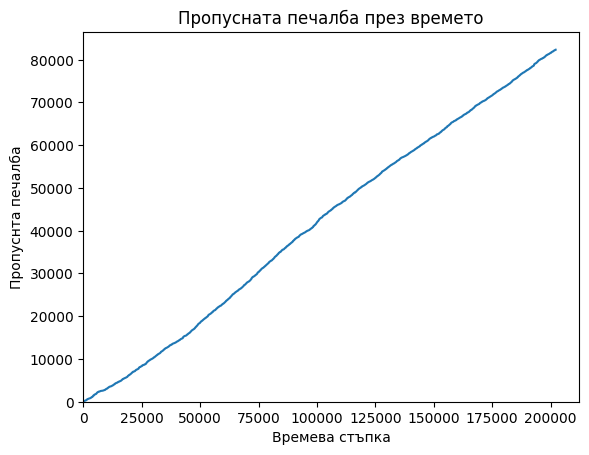

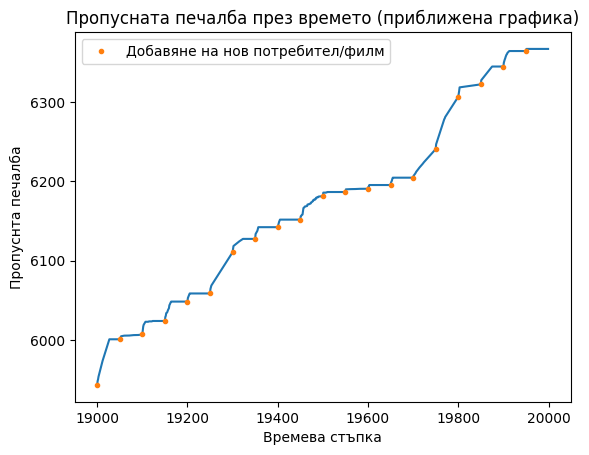

In [7]:
plt.plot(regret)
plt.xlabel("Времева стъпка")
plt.ylabel("Пропуснта печалба")
plt.title("Пропусната печалба през времето")
plt.xlim(0)
plt.ylim(0)
plt.show()
plt.plot([19000+i for i in range(1000)],regret[19000:20000])
plt.plot([19000+i*50 for i in range(20)],regret[19000:20000:50],'o',markersize=3,label="Добавяне на нов потребител/филм")
plt.xlabel("Времева стъпка")
plt.ylabel("Пропуснта печалба")
plt.title("Пропусната печалба през времето (приближена графика)")
plt.legend()
plt.show()

Метриката, която ще ни позволи да видим дали научените от нас признаци са правилни е точност (accuracy). Ще видим дали предпочитаният филм  на всеки потребител според алгоритъма е наистина този който знаем. Тази метрика можем да генерализираме на топ k предпочитани филми (k-accuracy). Тя показва дали най-предпочитаният филм според научените признаци е реално в топ k на най-предпочитаните филми.

In [8]:
def compute_score(features_users,features_movies,Ulearn,Vlearn,k):

    score = [0]
    for j in range(len(features_users)):
        add = 0
        if np.argmax([Ulearn[j].dot(Vlearn[i]) for i in range(207)]) == np.argmax([features_users[j].dot(features_movies[i]) for i in range(207)]):
            add = 1
        score.append(score[-1] + add)

    score5 = [0]
    for j in range(len(features_users)):
        add = 0
        if np.argmax([features_users[j].dot(features_movies[i]) for i in range(207)]) in np.argsort([Ulearn[j].dot(Vlearn[i]) for i in range(207)])[-1:-1-k:-1]:
            add = 1
        score5.append(score5[-1] + add)

    score = [si/len(features_users) for si in score]
    score5 = [si/len(features_users) for si in score5]

    return score,score5

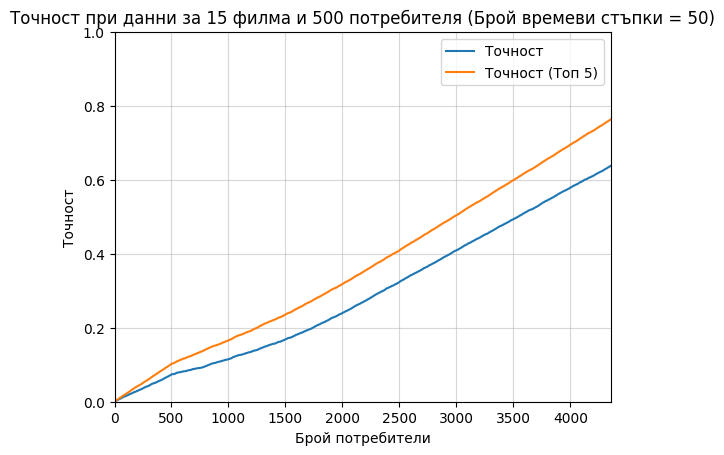

In [9]:
score,score5 = compute_score(features_users,features_movies,Ulearn,Vlearn,5)
plt.plot(score,label="Точност")
plt.plot(score5,label="Точност (Топ 5)")
plt.grid(alpha=0.5)
plt.xlabel("Брой потребители")
plt.xlim(0,len(features_users))
plt.legend()
plt.ylim(0,1)
plt.ylabel("Точност")
plt.title("Точност при данни за 15 филма и 500 потребителя (Брой времеви стъпки = 50)")
plt.show()

In [ ]:
print("Точност :",round(score[-1],4)*100, "%")
print("Точност Топ 5 :",round(score5[-1],4)*100, "%")

Точност : 63.75999999999999 %
Точност Топ 5 : 76.33 %


При 50 времеви стъпки (T_max = 50), научаваме до известна степен признаците, но не и изцяло. Забелязва се, че точността е по-ниска за потребители, които са добавени по-рано (точно след $n_0 = 500$), защото няма достатъчно филми от които да извлечем добре признаците. Тук точността не е много висока, но не ка видим какво ще се случи ако имаме повече филми и потребители при стартиране.

In [10]:

Ulearn,Vlearn,regret = LinUCB(features_movies,features_users,new_elems=7000,verbose=False,T_max=50,start=(100,2000),nb_sugg=5,big_step=2,proba=1/10)

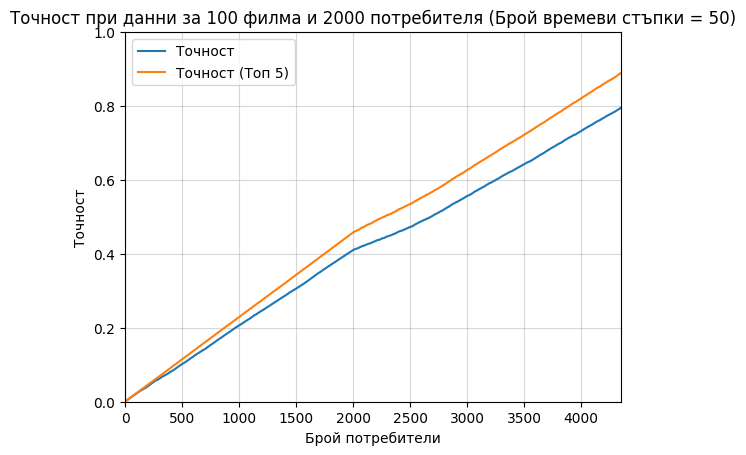

In [11]:
score,score5 = compute_score(features_users,features_movies,Ulearn,Vlearn,5)
plt.plot(score,label="Точност")
plt.plot(score5,label="Точност (Топ 5)")
plt.grid(alpha=0.5)
plt.xlabel("Брой потребители")
plt.xlim(0,len(features_users))
plt.legend()
plt.ylim(0,1)
plt.ylabel("Точност")
plt.title("Точност при данни за 100 филма и 2000 потребителя (Брой времеви стъпки = 50)")
plt.show()

In [12]:
print("Точност :",round(score[-1],4)*100, "%")
print("Точност Топ 5 :",round(score5[-1],4)*100, "%")

Точност : 79.52 %
Точност Топ 5 : 88.92 %


Получаваме по-добра точност. Също така в този случай след резултатите за 2000-ния потребител по-ясно се вижда разликата в точността преди и след да започнем да учим нови признаци

### 3.1 Използване на оценките в изчислението на печалбата

Нека видим какво ще се случи ако вместо да изчисляваме печалбата от признаците, получени чрез декомпозиране по синглулярни стойности, предлагаме само филми, които потребителя е видял спрямо матрицата с оценките. Ще изчислим печалбата, като използваме тези оценки вместо векторите с признаци за потребители и филми

Кодът долу връща списък с потребители гледали даден филм $M_i$ и списък с филми гледани от даден потребител $U_i$

In [ ]:
def what_is_seen(M):
    users_seen = [[] for i in range(n)]
    movies_seen = [[] for i in range(m)]
    for i in range(len(M)):
        for j in range(len(M[i])):
            if M[i][j] > 0: # If the rating is positive, user i has seen and rated film j
                users_seen[i].append(j)
                movies_seen[j].append(i)
    return users_seen,movies_seen

users_seen,movies_seen = what_is_seen(M)

Ще адаптираме предходният алгоритъм за да изчислява печалбите спрямо оценките.

In [ ]:
def MLinUCB_select_movie(est_features_user,est_features_movies,user_ind,user_seen,ratings,sigma,alpha,N,nb_sugg):
    prod_scal = [est_features_user.dot(est_features_movies[user_seen[i]])+alpha/np.sqrt(N[i]+1) for i in range(len(user_seen))]
    arg_movies = np.argsort(prod_scal)[-1:-1-nb_sugg:-1]
    chosen_movies = [user_seen[movie_i] for movie_i in arg_movies]
    rewards = [ratings[user_ind,chosen_movie] + np.random.normal(0,sigma) for chosen_movie in chosen_movies]
    return chosen_movies, rewards

# Same as above but movie and user swapped
def MLinUCB_select_user(est_features_movie,est_features_users,movie_ind,movie_seen,ratings,sigma,alpha,N,nb_sugg):
    prod_scal = [est_features_users[movie_seen[i]].dot(est_features_movie)+alpha/np.sqrt(N[i]+1) for i in range(len(movie_seen))]
    arg_users = np.argsort(prod_scal)[-1:-1-nb_sugg:-1]
    chosen_users = [movie_seen[user_i] for user_i in arg_users]
    rewards = [ratings[chosen_user,movie_ind] + np.random.normal(0,sigma) for chosen_user in chosen_users]
    return chosen_users, rewards

# Initialisation
def MLinUCB_init(m,d,lambd,fseen,maxf):
    V = lambd*np.identity(d)
    theta = np.zeros(d)
    D = np.zeros(d)
    out_seen = []
    for i in range(len(fseen)):
        if fseen[i] < maxf:
            out_seen.append(fseen[i])
        else:
            break
    N = np.zeros(len(out_seen))
    return V,D,theta,N,out_seen

def MLinUCB(features_movies,features_users,ratings,users_seen,movies_seen,lambd=0.1,sigma=0.5,new_elems=10,T_max=1000,start=(150,4000),nb_sugg=5,big_step=1,verbose=False,proba=1/4):
    if verbose:
        print("init")
    (n,d) = features_users.shape
    (m,_) = features_movies.shape
    (nb_movies,nb_users) = start
    features_users_l = features_users[:nb_users]
    features_movies_l = features_movies[:nb_movies]
    alpha = np.sqrt(2*np.log(T_max)/np.log(10))
    for elemi in range(new_elems):
        if nb_movies == m and nb_users == n:
            return features_users_l,features_movies_l
        elif nb_movies == m:
            nb_users += 1
            is_user = True
        elif nb_users == n:
            nb_movies += 1
            is_user = False
        else:
            r = np.random.rand()
            if r < proba:
                nb_movies += 1
                is_user = False
            else:
                nb_users += 1
                is_user = True
        if is_user:
            V,D,theta,N,seen = MLinUCB_init(nb_movies,d,lambd,users_seen[nb_users-1],nb_movies)
            if verbose:
                print(elemi,". add user ",nb_users)
                print("Have seen ",len(seen))
        else:
            V,D,theta,N,seen = MLinUCB_init(nb_movies,d,lambd,movies_seen[nb_movies-1],nb_users)
            if verbose:
                print(elemi,". add movie ",nb_movies)
                print("Seen by ",len(seen))
        for t in range(T_max):
            if is_user:
                chosen_movies,rewards = MLinUCB_select_movie(theta,features_movies_l,nb_users-1,seen,ratings,sigma,alpha,N,nb_sugg)
                for i in range(nb_sugg):
                    V += np.outer(features_movies_l[chosen_movies[i]],features_movies_l[chosen_movies[i]])
                    D += features_movies_l[chosen_movies[i]]*rewards[i]
                    N[seen.index(chosen_movies[i])]+= 1
                if t%big_step == 0:
                    theta = np.linalg.inv(V).dot(D)
            else:
                chosen_users,rewards = MLinUCB_select_user(theta,features_users_l,nb_movies-1,seen,ratings,sigma,alpha,N,nb_sugg)
                for i in range(nb_sugg):
                    V += np.outer(features_users_l[chosen_users[i]],features_users_l[chosen_users[i]])
                    D += features_users_l[chosen_users[i]]*rewards[i]
                    N[seen.index(chosen_users[i])]+= 1
                if t%big_step == 0:
                    theta = np.linalg.inv(V).dot(D)
        if is_user:
            features_users_l = np.vstack((features_users_l,[theta]))
        else:
            features_movies_l = np.vstack((features_movies_l,[theta]))
    return features_users_l,features_movies_l

In [ ]:

UlearnM,VlearnM = MLinUCB(features_movies,features_users,M,users_seen,movies_seen,new_elems=7000,verbose=False,T_max=100,start=(100,1000),nb_sugg=1,big_step=2,proba=1/20)

In [ ]:
def compute_score_M(matrix,users_seen,Ulearn,Vlearn,k):

    score = [0]
    for j in range(len(features_users)):
        add = 0
        if M[j,int(np.argmax([Ulearn[j].dot(Vlearn[users_seen[j][i]]) for i in range(len(users_seen[j]))]))] == max(M[j]):
            add = 1
        score.append(score[-1] + add)


    score = [si/len(features_users) for si in score]

    return score

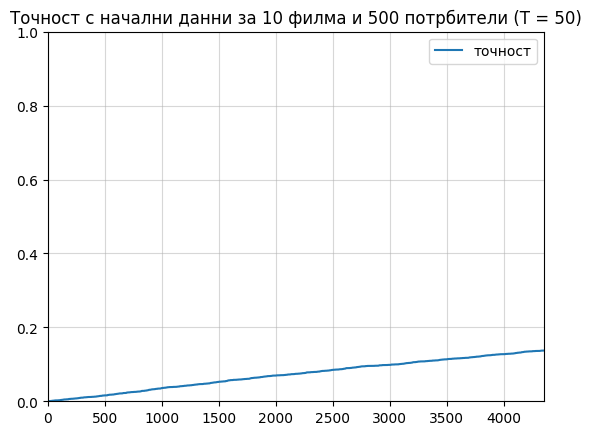

Точност : 13.721 %


In [ ]:
score = compute_score_M(M,users_seen,UlearnM,VlearnM,5)
plt.plot(score,label="точност")
plt.grid(alpha=0.5)
plt.xlim(0,len(features_users))
plt.legend()
plt.ylim(0,1)
plt.title("Точност с начални данни за 10 филма и 500 потрбители (T = 50)")
plt.show()
print("Точност :",round(score[-1]*100,4), "%")

Вижда се, че този алгоритъм изобщо не се спраявя с научаването на най-предпочитаните филми на потреибтелите. Това най-вероятно се дължи на на факта че оценките в матрицата имат доста близки стойности. Например потребител е оценил сравнително голям брой филми с оценка 5 и тогава ще бъде трудно да се разбере кой точно е най-предпочитан. Освен това ограничителен фактор е и размерът на данни откъм брой оценки.

### 3.2 Използване само на част от матрицата с оценки за потребители и филми

В предходните експерименти, признаците на потребители и филми, използвани в началото на работа на алгоритъма са извлечени с SVD от цялата матрица с филми, потребители и съответни оценки М. За по-голям реализъм искаме определни потребители и филми, които все още не са известни за препоръчващата система да се добавят последователно. Нека видим какво ще стане, ако декомпозираме по сингулярни стойности само част от цялата М и в началото на работа на алгоритъма се използват признаците от само тази подматрица.  

In [ ]:
subM = M[:2000,:100] # cut out part of the rating matrix M
subU, subs, subVt = svds(subM, k = K) # apply the SVD method for matrix factorization
subs = np.diag(subs)
subU = np.dot(subU,subs)
sub_features_users = subU
sub_features_movies = subVt.T

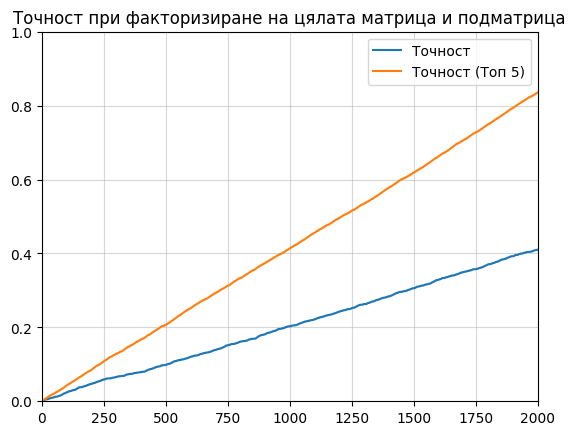

Точност : 41.0 %
Точност (Топ 5) : 83.55 %


In [ ]:
score = [0]
for j in range(len(sub_features_users)):
    add = 0
    if np.argmax([sub_features_users[j].dot(sub_features_movies[i]) for i in range(100)]) == np.argmax([features_users[j].dot(features_movies[i]) for i in range(100)]):
        add = 1
    score.append(score[-1] + add)

score3 = [0]
for j in range(len(sub_features_users)):
    add = 0
    if np.argmax([features_users[j].dot(features_movies[i]) for i in range(100)]) in np.argsort([sub_features_users[j].dot(sub_features_movies[i]) for i in range(100)])[-1:-1-5:-1]:
        add = 1
    score3.append(score3[-1] + add)

score = [si/len(sub_features_users) for si in score]
score3 = [si/len(sub_features_users) for si in score3]
plt.plot(score,label="Точност")
plt.plot(score3,label="Точност (Топ 5)")
plt.grid(alpha=0.5)
plt.xlim(0,len(sub_features_users))
plt.legend()
plt.ylim(0,1)
plt.title("Точност при факторизиране на подматрицата спрямо цялата матрица")
plt.show()
print("Точност :",round(score[-1],4)*100, "%")
print("Точност (Топ 5) :",round(score3[-1],4)*100, "%")

В графиката горе виждаме, че най-предпочитаният филм за всеки потребител драстично се различава спрямо двете матрици. Очаквано се наблюдава се по-ниска точност. Точност (Топ 5) е по-добра, тъй като потребителите подреждат топ 5 най-предпочитаните си филми сходно. Поне спрямо точност (топ 5) резултатите спрямо използването на цялата матрица с филми и потребители са подобни.

In [ ]:
def LinUCB_real(start_movies,start_users,features_movies,features_users,lambd=0.1,sigma=0.5,new_elems=10,T_max=1000,nb_sugg=5,big_step=1,verbose=False,proba=1/4):
    if verbose:
        print("init")
    (n,d) = features_users.shape
    (m,_) = features_movies.shape
    features_users_l = start_users
    nb_users = len(start_users)
    features_movies_l = start_movies
    nb_movies = len(start_movies)
    alpha = np.sqrt(2*np.log(T_max)/np.log(10))
    for elemi in range(new_elems):
        if nb_movies == m and nb_users == n:
            return features_users_l,features_movies_l
        elif nb_movies == m:
            nb_users += 1
            is_user = True
        elif nb_users == n:
            nb_movies += 1
            is_user = False
        else:
            r = np.random.rand()
            if r < proba:
                nb_movies += 1
                is_user = False
            else:
                nb_users += 1
                is_user = True
        if is_user:
            if verbose:
                print(elemi,". add user ",nb_users)
            V,D,theta,N = LinUCB_init(nb_movies,d,lambd)
        else:
            if verbose:
                print(elemi,". add movie ",nb_movies)
            V,D,theta,N = LinUCB_init(nb_users,d,lambd)
        for t in range(T_max):
            if is_user:
                chosen_movies,rewards,_ = LinUCB_select_movie(theta,features_movies_l,features_users[nb_users-1],features_movies,sigma,alpha,N,nb_movies,nb_sugg)
                for i in range(nb_sugg):
                    V += np.outer(features_movies_l[chosen_movies[i]],features_movies_l[chosen_movies[i]])
                    D += features_movies_l[chosen_movies[i]]*rewards[i]
                    N[chosen_movies[i]]+= 1
                if t%big_step == 0:
                    theta = np.linalg.inv(V).dot(D)
            else:
                chosen_users,rewards,_ = LinUCB_select_user(theta,features_users_l,features_users,features_movies[nb_movies-1],sigma,alpha,N,nb_users,nb_sugg)
                for i in range(nb_sugg):
                    V += np.outer(features_users_l[chosen_users[i]],features_users_l[chosen_users[i]])
                    D += features_users_l[chosen_users[i]]*rewards[i]
                    N[chosen_users[i]]+= 1
                if t%big_step == 0:
                    theta = np.linalg.inv(V).dot(D)
        if is_user:
            features_users_l = np.vstack((features_users_l,[theta]))
        else:
            features_movies_l = np.vstack((features_movies_l,[theta]))
    return features_users_l,features_movies_l

In [ ]:

UlearnR,VlearnR = LinUCB_real(sub_features_movies,sub_features_users,features_movies,features_users,new_elems=7000,verbose=False,T_max=50,nb_sugg=5,big_step=1,proba=1/10)

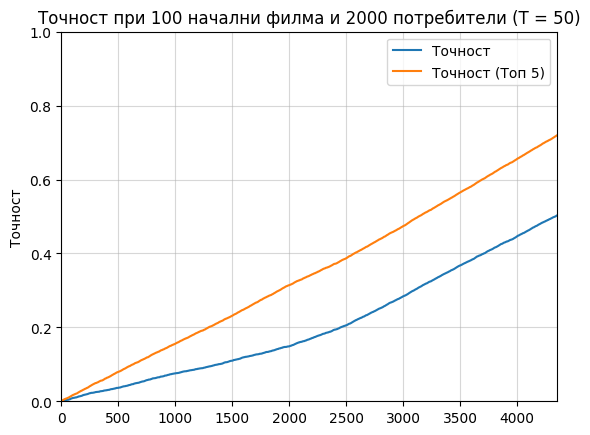

Точност : 50.3103 %
Точност (Топ 5) : 71.9835 %


In [ ]:
score,score3 = compute_score(features_users,features_movies,UlearnR,VlearnR,5)

plt.plot(score,label="Точност")
plt.plot(score3,label="Точност (Топ 5)")
plt.grid(alpha=0.5)
plt.xlim(0,len(features_users))
plt.legend()
plt.ylim(0,1)
plt.ylabel("Точност")
plt.title("Точност при 100 начални филма и 2000 потребители (T = 50)")
plt.show()
print("Точност :", round(score[-1]*100,4), "%")
print("Точност (Топ 5) :", round(score3[-1]*100,4), "%")

Виждаме че след обучение с LinUCB, точността се леко се повиши от 41% на 50%. Забелязва се обаче и спад в точност (топ 5) от 83% на 72%

### 3.3 Използване на стохастично градиентно спускане при разлагане на матриците


Нека вместо декомпозиране на сингулярни стойности (SVD), базирано единствено на операции от линейната алгебра, експериментираме с употреба на разлагане(декомпозиране) на матрици постредством стохастично градиентно спускане.
При много големи матрици, разлагането със стохастичното градиентно спускане вместо с SVD е по-скалируемо и може да се справи с по-големи набори от данни, понеже обработва данни една по една или на малки по-размер групи (mini-batches). Поради тази причина и разлагането със стохастичносто градиентно спуксане е по-подходящо за научаване в интерактивна ("онлайн") среда, тъй като обновява разлагането на матриците инкрементално.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math


def loadData(directory):
    ratings = pd.read_csv(directory + '/ratings.csv',
                          usecols=['userId', 'movieId', 'rating'])
    movies = pd.read_csv(directory + 'movies.csv')
    return ratings, movies


def Df2Numpy(ratings):
    ratingsMatrix = ratings.pivot(index='userId',
                                  columns='movieId',
                                  values='rating')
    ratingsMatrix = ratingsMatrix.fillna(0)
    R = ratingsMatrix.to_numpy()
    return R


class MatrixFactorization():
    """
    Matrix Factorization Class
    - аssumes ratings is a m x n Numpy array
    - nFactors is the intermediate dimension k of the Matrices U and V
    - lambdaReg адн muReg are regularization parameters
    """
    def __init__(self,
                 ratings,
                 nFactors=10,
                 alpha=0.01,
                 lambdaReg=0.0,
                 muReg=0.0,
                 biasReg=0.0,
                 maxIter=50,
                 epsilon=0.001,
                 trainFrac=0.8,
                 valFrac=0.1,
                 testFrac=0.1):
        self.R = ratings
        self.nFactors = nFactors
        self.lambdaReg = lambdaReg
        self.alpha = alpha
        self.muReg = muReg
        self.biasReg = biasReg
        self.maxIter = maxIter
        self.epsilon = 0.1
        self.nUsers, self.nMovies = ratings.shape
        self.trainFrac = trainFrac
        self.valFrac = valFrac
        self.testFrac = testFrac

        self.U = np.random.normal(scale=(1. / self.nFactors),
                                  size=(self.nUsers, self.nFactors))
        self.V = np.random.normal(scale=(1. / self.nFactors),
                                  size=(self.nMovies, self.nFactors))

    # convert matrix to a list of tuples (row, column, value) with only nonzero entries of the matrix
    def matrix2Samples(self, matrix):
        samples = [(i, j, matrix[i, j]) for i in range(matrix.shape[0])
                   for j in range(matrix.shape[1]) if matrix[i, j] > 0]
        return samples

    # convert list of tuples (row, column, value) to a matrix of size m x n
    def samples2Matrix(self, samples, m, n):
        matrix = np.zeros(m, n)
        for s in samples:
            i, j, v = s
            matrix[i, j] = v
            return matrix

    # Initialise target matrices U and V using normally distributed numbers
    def randomInit(self):
        self.U = np.random.normal(scale=(1. / self.nFactors),
                                  size=(self.nUsers, self.nFactors))
        self.V = np.random.normal(scale=(1. / self.nFactors),
                                  size=(self.nMovies, self.nFactors))

    # Split the observed data (nonzero entries) into a training set and a validation set
    # by removing 10 grades per user and assigning them to the validation set
    def splitTrainValSets(self, nGrades=10):
        valMatrix = np.zeros(self.R.shape)
        trainMatrix = self.R.copy()
        for i in range(self.R.shape[0]):
            valRatingsIds = np.random.choice(self.R[i, :].nonzero()[0],
                                             size=min(nGrades,len(self.R[i,:].nonzero()[0])//2),
                                             replace=False)
            trainMatrix[i, valRatingsIds] = 0
            valMatrix[i, valRatingsIds] = self.R[i, valRatingsIds]

        assert (np.all(trainMatrix * valMatrix) == 0)
        trainSamples = self.matrix2Samples(trainMatrix)
        valSamples = self.matrix2Samples(valMatrix)
        return trainSamples, valSamples

    # sgd iteration
    def stochasticGradientDescentPass(self, trainSamples):
        for s in trainSamples:
            i, j, _ = s
            r_hat_ij = np.dot(self.U[i, :], self.V.T[:, j])
            #+self.userBias[i] + self.movieBias[j]
            eij = self.R[i, j] - r_hat_ij
            tmpU = np.zeros(self.nFactors)
            tmpV = np.zeros(self.nFactors)
            for q in range(self.nFactors):
                tmpU[q] = self.U[i, q] + self.alpha * (
                    eij * self.V[j, q] - self.lambdaReg * self.U[i, q])
                tmpV[q] = self.V[j, q] + self.alpha * (
                    eij * self.U[i, q] - self.muReg * self.V[j, q])


            self.U[i, :] = tmpU[:]
            self.V[j, :] = tmpV[:]

        return self.U, self.V
    # sgd
    def stochasticGradientDescent(self, logging=True,nGrades=10):
        history = {'trainErrors': [], 'valErrors': []}
        self.randomInit()
        trainSamples, valSamples = self.splitTrainValSets(nGrades)
        for i in range(self.maxIter):
            print("Iteration : ",i)
            np.random.shuffle(trainSamples)
            U, V = self.stochasticGradientDescentPass(trainSamples)
            trainError = self.computeTotalErrorSamples(trainSamples)

            if logging:
                valError = self.computeTotalErrorSamples(valSamples)
                history['trainErrors'].append(trainError)
                history['valErrors'].append(valError)
            if trainError < self.epsilon:
                break

        history['trainError'] = self.computeTotalErrorSamples(trainSamples)
        history['valError'] = self.computeTotalErrorSamples(valSamples)

        return U, V, history

    def plotHistory(self, history):
        plt.plot(history['trainErrors'], label='Грешка върху тренировъчни данни')
        plt.plot(history['valErrors'], label='Грешка върху валидационни данни')
        plt.title('Стойности на грешката през обучението')
        plt.ylabel('MSE')
        plt.xlabel('Итерация')
        plt.legend()
        plt.show()

    def computeTotalErrorSamples(self, data):
        error = 0
        if len(data) == 0:
            return 0
        for s in data:
            i, j, r = s
            error += (r - np.dot(self.U[i, :], self.V.T[:, j]))**2
        return math.sqrt(error / len(data))

    def computeApproximatedMatrix(self, U, V):
        return np.dot(U, V.T)

Нека извлечем признаците на потребителите и филмите за цялата матрица M

In [ ]:
mf = MatrixFactorization(M,maxIter=20)
gU,gV,h = mf.stochasticGradientDescent()

Iteration :  0
Iteration :  1
Iteration :  2
Iteration :  3
Iteration :  4
Iteration :  5
Iteration :  6
Iteration :  7
Iteration :  8
Iteration :  9
Iteration :  10
Iteration :  11
Iteration :  12
Iteration :  13
Iteration :  14
Iteration :  15
Iteration :  16
Iteration :  17
Iteration :  18
Iteration :  19


Сега нека извлечем същото за подматрица с първите 3000 потребители и 150 филма

In [ ]:
sub_mf = MatrixFactorization(M[:3000,:150],maxIter=20)
sub_gU,sub_gV,sub_h = sub_mf.stochasticGradientDescent()

Iteration :  0
Iteration :  1
Iteration :  2
Iteration :  3
Iteration :  4
Iteration :  5
Iteration :  6
Iteration :  7
Iteration :  8
Iteration :  9
Iteration :  10
Iteration :  11
Iteration :  12
Iteration :  13
Iteration :  14
Iteration :  15
Iteration :  16
Iteration :  17
Iteration :  18
Iteration :  19


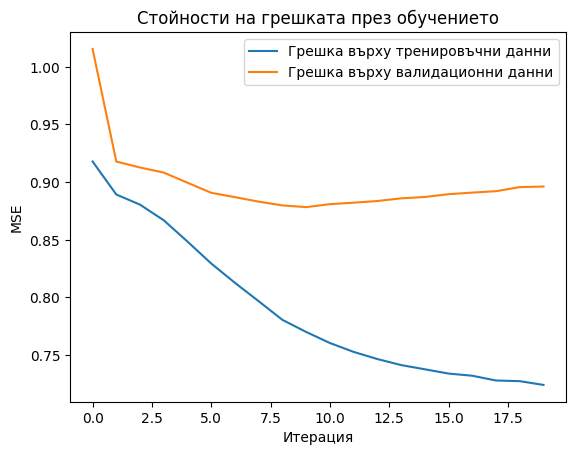

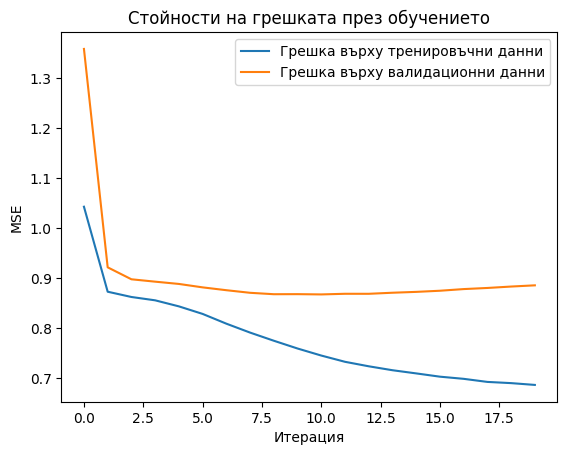

In [ ]:
mf.plotHistory(h)
sub_mf.plotHistory(sub_h)

В графиката, се вижда че е налице "пренагаждане" към тренировъчните данни. Това най-вероятно се дължи на употребата на малко тренировъчни данни в експеримента (4000 потребители и 200 филма).

Нека видим колко сходно се държат двата варианта обучени на цялата матрица M и подматрицата от гледна точка на точност

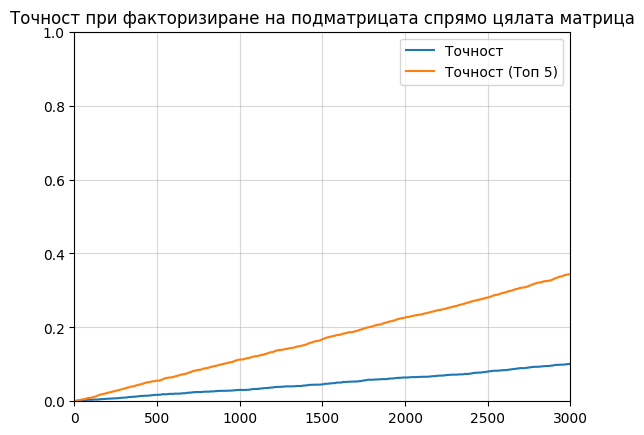

Точност : 10.1 %
Точност (Топ 5) : 34.4333 %


In [ ]:
score = [0]
for j in range(len(sub_gU)):
    add = 0
    if np.argmax([sub_gU[j].dot(sub_gV[i]) for i in range(150)]) == np.argmax([gU[j].dot(gV[i]) for i in range(150)]):
        add = 1
    score.append(score[-1] + add)

score3 = [0]
for j in range(len(sub_gU)):
    add = 0
    if np.argmax([gU[j].dot(gV[i]) for i in range(150)]) in np.argsort([sub_gU[j].dot(sub_gV[i]) for i in range(150)])[-1:-1-5:-1]:
        add = 1
    score3.append(score3[-1] + add)


score = [si/len(sub_gU) for si in score]
score3 = [si/len(sub_gU) for si in score3]
plt.plot(score,label="Точност")
plt.plot(score3,label="Точност (Топ 5)")
plt.grid(alpha=0.5)
plt.xlim(0,len(sub_gU))
plt.legend()
plt.ylim(0,1)
plt.title("Точност при факторизиране на подматрицата спрямо цялата матрица")
plt.show()
print("Точност :",round(score[-1]*100,4), "%")
print("Точност (Топ 5) :",round(score3[-1]*100,4), "%")

Отново виждаме, че признаците извлечени от матрицата М и тези извлечени от подматрицата дават значително различни препоръки за филми за даден потребител. Следователно точността, която получаваме при това сравнение е ниска.

Нека разгледаме друга метрика, която обикновено не се използва за онлайн модели и модели от тип "многорък бандит", но все пак намира широко приложение в препоръчващите системи, а именно - RMSE квадратен корен от средната квадратична грешка.

In [ ]:
def loss_rmse(U,V,M):
    error = 0
    count = 0
    L = []
    for i in range(len(M)):
        for j in range(len(M[0])):
            r = M[i,j]
            if r > 0:
                error += (r - np.dot(U[i,:], V.T[:,j]))**2
                count += 1
        L.append(np.sqrt(error/count))
    return np.sqrt(error /count),L


In [ ]:
print(loss_rmse(gU[:3000],gV[:150],M[:3000,:150])[0])
print(loss_rmse(sub_gU,sub_gV,M[:3000,:150])[0])

0.7400532763152666
0.7296512359682203


Забелязваме, че RMSE за двата варианта е почти идентична, макар и до известна степен това да се дължи на "пренагаждането"

Нека продължим експеримента с тези нови признаци

In [ ]:
np.random.seed(0)
UlearnGR,VlearnGR = LinUCB_real(sub_gV,sub_gU,gV,gU,new_elems=7000,verbose=False,T_max=100,nb_sugg=5,big_step=2,proba=1/10)

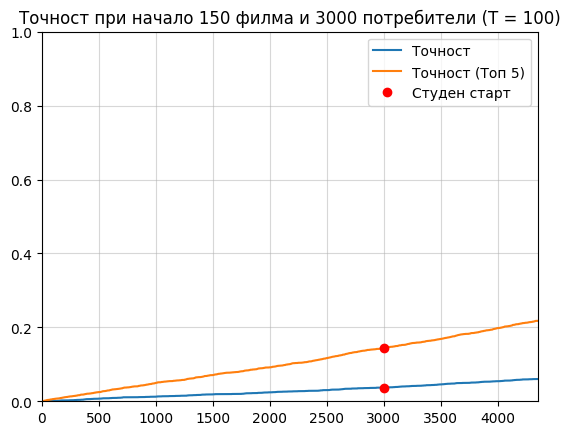

Точност : 6.02 %
Точност (Топ 5) : 21.77 %


In [ ]:
score,score3 = compute_score(features_users,features_movies,UlearnGR,VlearnGR,5)

plt.plot(score,label="Точност")
plt.plot(score3,label="Точност (Топ 5)")
plt.plot([3000],[score[3000]],'o',color="red",label="Студен старт")
plt.plot([3000],[score3[3000]],'o',color="red")
plt.grid(alpha=0.5)
plt.xlim(0,len(gU))
plt.legend()
plt.ylim(0,1)
plt.title("Точност при начало 150 филма и 3000 потребители (T = 100)")
plt.show()
print("Точност :",round(score[-1],4)*100, "%")
print("Точност (Топ 5) :",round(score3[-1],4)*100, "%")

Очаквано получена точност е изключително неточна, но както видяхме това не задължително е така за RMSE метриката.

Нека видим каква е тя.

In [ ]:
lg,Lg = loss_rmse(gU,gV,M)
ll,Ll = loss_rmse(UlearnGR,VlearnGR,M)
lp,_ = loss_rmse(UlearnGR[3000:],VlearnGR,M[3000:,:])

Грешка за признаци от SGD : 0.750606995674708
Грешка за научени признаци : 0.8018064624298175
Грешка за научени признаци на потребители > 3000 : 0.8262350422625581


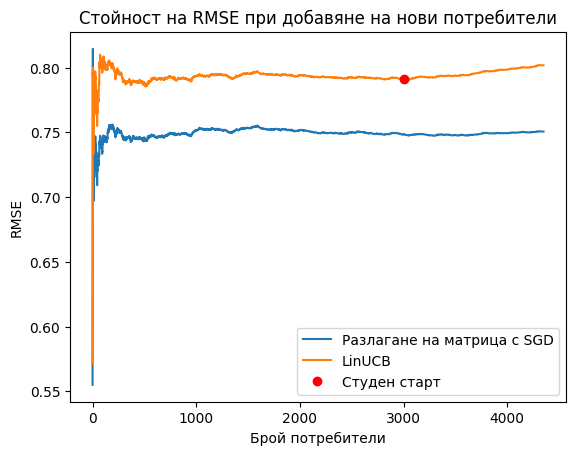

In [ ]:
print("Грешка за признаци от SGD :",lg)
print("Грешка за научени признаци :",ll)
print("Грешка за научени признаци на потребители > 3000 :",lp)
plt.plot(Lg,label="Разлагане на матрица с SGD")
plt.plot(Ll,label="LinUCB")
plt.plot([3000],[Ll[3000]],'o',color="red",label="Студен старт")
plt.title("Стойност на RMSE при добавяне на нови потребители")
plt.xlabel("Брой потребители")
plt.ylabel("RMSE")
plt.legend()
plt.show()

Въпреки, че е малко по-висока от грешката при разлагането на матрици с SGD, може да се каже че резултатът за потребителксите признаци научени от LinUCB алгоритъма е добър за RMSE.

Сега нека приложим едновременно различните експерименти от по-рано
- **Динамична система** с итеративно добавяне на потребители и филми
- Разлагане на матрицата със стохастично градиетно спускане
- Стартирането със знания(признаци) само за част от потребителите и филмите
- Печалба базирана на оценки от гледани филми

In [ ]:
def MLinUCB_real(start_movies,start_users,ratings,users_seen,movies_seen,lambd=0.1,sigma=0.5,new_elems=10,T_max=1000,nb_sugg=5,big_step=1,verbose=False,proba=1/4):
    if verbose:
        print("init")
    (n,m) = ratings.shape
    d = len(start_movies[0])
    (nb_movies,nb_users) = (len(start_movies),len(start_users))
    features_users_l = start_users
    features_movies_l = start_movies
    alpha = np.sqrt(2*np.log(T_max)/np.log(10))
    for elemi in range(new_elems):
        if nb_movies == m and nb_users == n:
            return features_users_l,features_movies_l
        elif nb_movies == m:
            nb_users += 1
            is_user = True
        elif nb_users == n:
            nb_movies += 1
            is_user = False
        else:
            r = np.random.rand()
            if r < proba:
                nb_movies += 1
                is_user = False
            else:
                nb_users += 1
                is_user = True
        if is_user:
            V,D,theta,N,seen = MLinUCB_init(nb_movies,d,lambd,users_seen[nb_users-1],nb_movies)
            if verbose:
                print(elemi,". add user ",nb_users)
                print("Have seen ",len(seen))
        else:
            if verbose:
                print(elemi,". add movie ",nb_movies)
            V,D,theta,N,seen = MLinUCB_init(nb_movies,d,lambd,movies_seen[nb_movies-1],nb_users)
        for t in range(T_max):
            if is_user:
                chosen_movies,rewards = MLinUCB_select_movie(theta,features_movies_l,nb_users-1,seen,ratings,sigma,alpha,N,nb_sugg)
                for i in range(nb_sugg):
                    V += np.outer(features_movies_l[chosen_movies[i]],features_movies_l[chosen_movies[i]])
                    D += features_movies_l[chosen_movies[i]]*rewards[i]
                    N[seen.index(chosen_movies[i])]+= 1
                if t%big_step == 0:
                    theta = np.linalg.inv(V).dot(D)
            else:
                chosen_users,rewards = MLinUCB_select_user(theta,features_users_l,nb_movies-1,seen,ratings,sigma,alpha,N,nb_sugg)
                for i in range(nb_sugg):
                    V += np.outer(features_users_l[chosen_users[i]],features_users_l[chosen_users[i]])
                    D += features_users_l[chosen_users[i]]*rewards[i]
                    N[seen.index(chosen_users[i])]+= 1
                if t%big_step == 0:
                    theta = np.linalg.inv(V).dot(D)
        if is_user:
            features_users_l = np.vstack((features_users_l,[theta]))
        else:
            features_movies_l = np.vstack((features_movies_l,[theta]))

    return features_users_l,features_movies_l


Нека първо пробваме с малък брой стъпки $T = 25$

In [ ]:
np.random.seed(0)
UlearnGR,VlearnGR = LinUCB_real(sub_gV,sub_gU,gV,gU,new_elems=7000,verbose=False,T_max=25,nb_sugg=5,big_step=1,proba=1/10)

np.random.seed(0)
UlearnGRM,VlearnGRM = MLinUCB_real(sub_gV,sub_gU,M,users_seen,movies_seen,new_elems=7000,verbose=False,T_max=25,nb_sugg=5,big_step=1,proba=1/10)

Грешка за разлагане на матрици с SGD : 0.7528786306164275
Грешка за научени признаци (използване на признаци): 0.8417104201717747
Грешка за научени признаци на потребители > 3000 (използване на признаци) : 0.8922036213048428
Грешка за научени признаци (използване на оценки): 1.0228533735469942
Грешка за научени признаци на потребители > 3000  (използване на оценки) : 1.3386361229260362


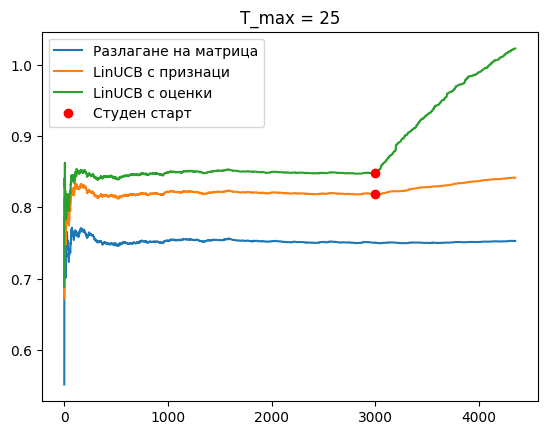

In [ ]:
llvf,Llvf = loss_rmse(UlearnGR,VlearnGR,M)
llvm,Llvm = loss_rmse(UlearnGRM,VlearnGRM,M)
lpf,_ = loss_rmse(UlearnGR[3000:],VlearnGR,M[3000:,:])
lpm,_ = loss_rmse(UlearnGRM[3000:],VlearnGRM,M[3000:,:])
print("Грешка за разлагане на матрици с SGD :",lg)
print("Грешка за научени признаци (използване на признаци):",llvf)
print("Грешка за научени признаци на потребители > 3000 (използване на признаци) :",lpf)
print("Грешка за научени признаци (използване на оценки):",llvm)
print("Грешка за научени признаци на потребители > 3000  (използване на оценки) :",lpm)

plt.plot(Lg,label="Разлагане на матрица")
plt.plot(Llvf,label="LinUCB с признаци")
plt.plot(Llvm,label="LinUCB с оценки")
plt.plot([3000],[Llvf[2999]],'o',color="red",label="Студен старт")
plt.plot([3000],[Llvm[2999]],'o',color="red")
plt.title("T_max = 25")
plt.legend()
plt.show()

Виждаме, че при LinUCB с реални оценки (зелена крива), алгоритъма изпитва затруднение да научи признаци на нови потребители. Това вероятно се  дължи на малкото данни с които тренираме. Нека видим какво се случва при по-голям брой стъпки. Например $T = 100$

In [ ]:
np.random.seed(0)
UlearnGR,VlearnGR = LinUCB_real(sub_gV,sub_gU,gV,gU,new_elems=7000,verbose=False,T_max=100,nb_sugg=5,big_step=1,proba=1/10)

np.random.seed(0)
UlearnGRM,VlearnGRM = MLinUCB_real(sub_gV,sub_gU,M,users_seen,movies_seen,new_elems=7000,verbose=False,T_max=100,nb_sugg=5,big_step=1,proba=1/10)

Грешка за разлагане на матрици с SGD : 0.7528786306164275
Грешка за научени признаци (използване на признаци): 0.8034628116489534
Грешка за научени признаци на потребители > 3000 (използване на признаци) : 0.8268757766481786
Грешка за научени признаци (използване на оценки): 0.9124907553072902
Грешка за научени признаци на потребители > 3000  (използване на оценки) : 1.1455225106201465


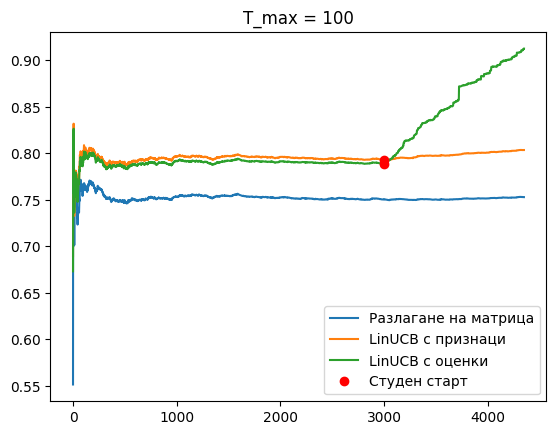

In [ ]:
llvf,Llvf = loss_rmse(UlearnGR,VlearnGR,M)
llvm,Llvm = loss_rmse(UlearnGRM,VlearnGRM,M)
lpf,_ = loss_rmse(UlearnGR[3000:],VlearnGR,M[3000:,:])
lpm,_ = loss_rmse(UlearnGRM[3000:],VlearnGRM,M[3000:,:])
print("Грешка за разлагане на матрици с SGD :",lg)
print("Грешка за научени признаци (използване на признаци):",llvf)
print("Грешка за научени признаци на потребители > 3000 (използване на признаци) :",lpf)
print("Грешка за научени признаци (използване на оценки):",llvm)
print("Грешка за научени признаци на потребители > 3000  (използване на оценки) :",lpm)

plt.plot(Lg,label="Разлагане на матрица")
plt.plot(Llvf,label="LinUCB с признаци")
plt.plot(Llvm,label="LinUCB с оценки")
plt.plot([3000],[Llvf[2999]],'o',color="red",label="Студен старт")
plt.plot([3000],[Llvm[2999]],'o',color="red")
plt.title("T_max = 100")
plt.legend()
plt.show()

Резултатите са по-добри, но грешката за нови елементи е все още висока. Нека увеличим броя времеви стъпки още (на $T = 500$)

In [ ]:
np.random.seed(0)
UlearnGR,VlearnGR = LinUCB_real(sub_gV,sub_gU,gV,gU,new_elems=7000,verbose=False,T_max=500,nb_sugg=5,big_step=2,proba=1/10)

np.random.seed(0)
UlearnGRM,VlearnGRM = MLinUCB_real(sub_gV,sub_gU,M,users_seen,movies_seen,new_elems=7000,verbose=False,T_max=500,nb_sugg=5,big_step=2,proba=1/10)

Грешка за разлагане на матрици с SGD : 0.7528786306164275
Грешка за научени признаци (използване на признаци): 0.7958745228618486
Грешка за научени признаци на потребители > 3000 (използване на признаци) : 0.8218195788316447
Грешка за научени признаци (използване на оценки): 0.85705735241518
Грешка за научени признаци на потребители > 3000  (използване на оценки) : 1.0099462877478258


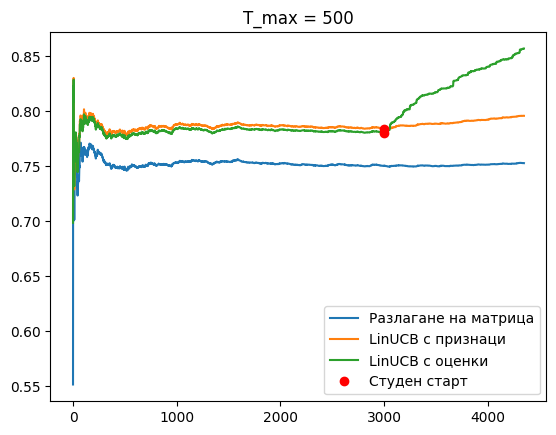

In [ ]:
llvf,Llvf = loss_rmse(UlearnGR,VlearnGR,M)
llvm,Llvm = loss_rmse(UlearnGRM,VlearnGRM,M)
lpf,_ = loss_rmse(UlearnGR[3000:],VlearnGR,M[3000:,:])
lpm,_ = loss_rmse(UlearnGRM[3000:],VlearnGRM,M[3000:,:])
print("Грешка за разлагане на матрици с SGD :",lg)
print("Грешка за научени признаци (използване на признаци):",llvf)
print("Грешка за научени признаци на потребители > 3000 (използване на признаци) :",lpf)
print("Грешка за научени признаци (използване на оценки):",llvm)
print("Грешка за научени признаци на потребители > 3000  (използване на оценки) :",lpm)

plt.plot(Lg,label="Разлагане на матрица")
plt.plot(Llvf,label="LinUCB с признаци")
plt.plot(Llvm,label="LinUCB с оценки")
plt.plot([3000],[Llvf[2999]],'o',color="red",label="Студен старт")
plt.plot([3000],[Llvm[2999]],'o',color="red")
plt.title("T_max = 500")
plt.legend()
plt.show()

Този път RMSE грешката изглежда по-добре дори за добавените по-късно елементи. Въпреки това, моделът не е напълно реалистичен понеже са необходими 500 стъпки или 500 предположения за филм на даден потребител, за да научим неговите признаци до такава степен, че да иамме сравнително ниска RMSE грешка. Освен това данните не са разделени на тренировъчни и валидационни данни. Отбелязваме, че резултатите за варианта на алгоритъма, използващ признаци извлечени от матрицата са добри.

### 3.4 Разделяне на тренировъчни и тестови данни

Към момента постигнахме RMSE ($< 1$), но в измерването влизат и данните върху, които тренираме. Нека видим какъв резултат за RMSE ще получим, ако ги разделим

Ще разделим матрицата с оценки на две матрици. Едната ще използваме за трениране, а другата за тестване. Ще ги разделим така че ще премахнем ненулеви 10 оценки за всеки потребител и ще ги добавим към валидационната матрица

In [ ]:
def splitTrainValSets(ratings, nGrades=10):
        valMatrix = np.zeros(ratings.shape)
        trainMatrix = ratings.copy()
        for i in range(ratings.shape[0]):
            valRatingsIds = np.random.choice(ratings[i, :].nonzero()[0],
                                             size=min(nGrades,len(ratings[i,:].nonzero()[0])//2),
                                             replace=False)
            trainMatrix[i, valRatingsIds] = 0
            valMatrix[i, valRatingsIds] = ratings[i, valRatingsIds]

        assert (np.all(trainMatrix * valMatrix) == 0)
        return trainMatrix, valMatrix


M_train, M_test = splitTrainValSets(M,nGrades=5)

In [ ]:
mftrain = MatrixFactorization(M_train[:3000,:150],maxIter=20)
gUtrain,gVtrain,h = mftrain.stochasticGradientDescent(0)


Iteration :  0
Iteration :  1
Iteration :  2
Iteration :  3
Iteration :  4
Iteration :  5
Iteration :  6
Iteration :  7
Iteration :  8
Iteration :  9
Iteration :  10
Iteration :  11
Iteration :  12
Iteration :  13
Iteration :  14
Iteration :  15
Iteration :  16
Iteration :  17
Iteration :  18
Iteration :  19


In [ ]:
loss_train,_ = loss_rmse(gUtrain,gVtrain,M_train[:3000,:150])
loss_test,_ = loss_rmse(gUtrain,gVtrain,M_test[:3000,:150])
print("RMSE върху тренировъчни данни :",loss_train)
print("RMSE върху тестови данни :",loss_test)

RMSE върху тренировъчни данни : 0.7334949288357053
RMSE върху тестови данни : 0.8963650410010615


In [ ]:
mftrain_complete = MatrixFactorization(M_train,maxIter=20)
gUtrain_complete,gVtrain_complete,h = mftrain_complete.stochasticGradientDescent(0)


Iteration :  0
Iteration :  1
Iteration :  2
Iteration :  3
Iteration :  4
Iteration :  5
Iteration :  6
Iteration :  7
Iteration :  8
Iteration :  9
Iteration :  10
Iteration :  11
Iteration :  12
Iteration :  13
Iteration :  14
Iteration :  15
Iteration :  16
Iteration :  17
Iteration :  18
Iteration :  19


In [ ]:
loss_train,_ = loss_rmse(gUtrain_complete,gVtrain_complete,M_train)
loss_test,_ = loss_rmse(gUtrain_complete,gVtrain_complete,M_test)
print("RMSE върху тренировъчни данни :",loss_train)
print("RMSE върху тестови данни :",loss_test)

RMSE върху тренировъчни данни : 0.7534733440960426
RMSE върху тестови данни : 0.9104026852183451


### 3.5 Вариант на модела с признаци, извлечени от тренировъчната матрица

Нека първо тестваме варианта на алгоритъма, който използва извлечени признаци от матрицата с тренировъчни данни.

In [ ]:
np.random.seed(0)
lfU_train,lfV_train = LinUCB_real(gVtrain,gUtrain,gVtrain_complete,gUtrain_complete,new_elems=7000,verbose=False,T_max=100,nb_sugg=5,big_step=2,proba=1/10)

RMSE върху тренировъчни данни : 0.8216672141024606
RMSE върху тестови данни : 0.9318942859401936
RMSE върху тренировъчни данни (U_i > 3000) : 0.8441396546588913
RMSE върху тестови данни (U_i > 3000) : 0.9282848614123278


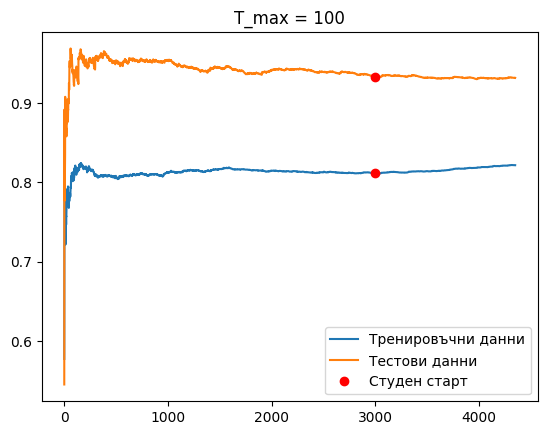

In [ ]:
loss_train,L_train = loss_rmse(lfU_train,lfV_train,M_train)
loss_test,L_test = loss_rmse(lfU_train,lfV_train,M_test)
print("RMSE върху тренировъчни данни :",loss_train)
print("RMSE върху тестови данни :",loss_test)
loss_train,_ = loss_rmse(lfU_train[3000:],lfV_train,M_train[3000:,:])
loss_test,_ = loss_rmse(lfU_train[3000:],lfV_train,M_test[3000:,:])
print("RMSE върху тренировъчни данни (U_i > 3000) :",loss_train)
print("RMSE върху тестови данни (U_i > 3000) :",loss_test)
plt.plot(L_train,label="Тренировъчни данни")
plt.plot(L_test,label="Тестови данни")
plt.plot([2999],[L_train[2999]],'o',color="red",label="Студен старт")
plt.plot([2999],[L_test[2999]],'o',color="red")
plt.title("T_max = 100")
plt.legend()
plt.show()

След разделяенто, RMSE се повиши малко, но остава сравнително добро като стойност

### 3.6 Вариант на модела с реални оценки

Тук ще тренираме алгоритъма само с реални оценки, които той е дал. Този вариант показа много лоши резултати в предходните експерименти, но е по-реалистичен и затова го разглеждаме отново

In [ ]:
users_seen_train,movies_seen_train = what_is_seen(M_train)

Нeка първо пробваме с $T_{max} = 100$

In [ ]:
np.random.seed(0)
lUtrain,lVtrain = MLinUCB_real(gVtrain,gUtrain,M_train,users_seen_train,movies_seen_train,new_elems=7000,verbose=False,T_max=100,nb_sugg=5,big_step=2,proba=1/10)


RMSE върху тренировъчни данни : 0.8754769829203178
RMSE върху тестови данни : 1.1110173559625165
RMSE върху тренировъчни данни (U_i > 3000) : 1.0371336545002043
RMSE върху тестови данни (U_i > 3000) : 1.452100917159937


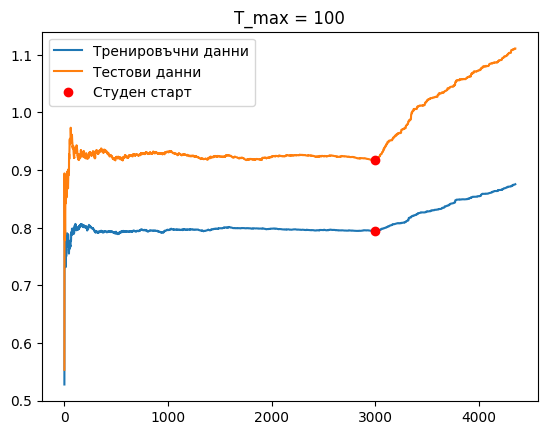

In [ ]:
loss_train,L_train = loss_rmse(lUtrain,lVtrain,M_train)
loss_test,L_test = loss_rmse(lUtrain,lVtrain,M_test)
print("RMSE върху тренировъчни данни :",loss_train)
print("RMSE върху тестови данни :",loss_test)
loss_train,_ = loss_rmse(lUtrain[3000:],lVtrain,M_train[3000:,:])
loss_test,_ = loss_rmse(lUtrain[3000:],lVtrain,M_test[3000:,:])
print("RMSE върху тренировъчни данни (U_i > 3000) :",loss_train)
print("RMSE върху тестови данни (U_i > 3000) :",loss_test)
plt.plot(L_train,label="Тренировъчни данни")
plt.plot(L_test,label="Тестови данни")
plt.plot([2999],[L_train[2999]],'o',color="red",label="Студен старт")
plt.plot([2999],[L_test[2999]],'o',color="red")
plt.title("T_max = 100")
plt.legend()
plt.show()

Очаквано грешката се увевеличи значително за новите елементи и дори още повече за тестовите данни. Нека видим какво се случва при ($T_{max} = 500$)

In [ ]:
np.random.seed(0)
lUtrain,lVtrain = MLinUCB_real(gVtrain,gUtrain,M_train,users_seen_train,movies_seen_train,new_elems=7000,verbose=False,T_max=500,nb_sugg=5,big_step=4,proba=1/10)

RMSE върху тренировъчни данни : 0.8581485925941449
RMSE върху тестови данни : 1.1057850294241285
RMSE върху тренировчни данни (U_i > 3000) : 1.0037878027569624
RMSE върху тестови данни (U_i > 3000) : 1.4492685577616233


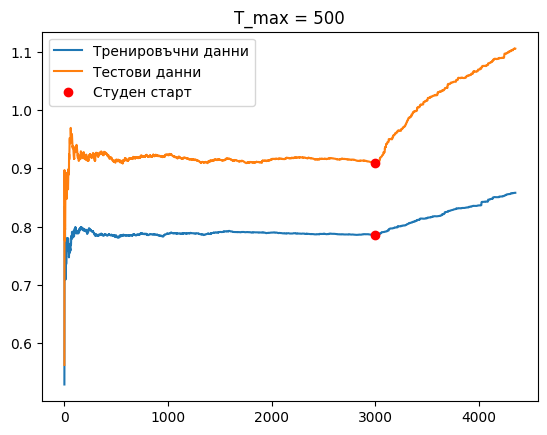

In [ ]:
loss_train,L_train = loss_rmse(lUtrain,lVtrain,M_train)
loss_test,L_test = loss_rmse(lUtrain,lVtrain,M_test)
print("RMSE върху тренировъчни данни :",loss_train)
print("RMSE върху тестови данни :",loss_test)
loss_train,_ = loss_rmse(lUtrain[3000:],lVtrain,M_train[3000:,:])
loss_test,_ = loss_rmse(lUtrain[3000:],lVtrain,M_test[3000:,:])
print("RMSE върху тренировчни данни (U_i > 3000) :",loss_train)
print("RMSE върху тестови данни (U_i > 3000) :",loss_test)
plt.plot(L_train,label="Тренировъчни данни")
plt.plot(L_test,label="Тестови данни")
plt.plot([2999],[L_train[2999]],'o',color="red",label="Студен старт")
plt.plot([2999],[L_test[2999]],'o',color="red")
plt.title("T_max = 500")
plt.legend()
plt.show()

Макар и с леко подобрение, резултатът върху тестовите данни е все така незадоволитен. Изглежда този подход работи доста по-зле. Вероятно това се дължи на малкото оценки, с които разполагаме за всеки потребител и съответно установяването на адекватни признаци само на база тези данни е непостижимо

Тъй като моделите от тип "многорък бандит" обикновено се използват за конкретна препоръка, а не за предсказване на оценка (RMSE), нека видим точността тоест дали филмите, които алгоритъма препоръчва наистина са такива, които потребителя ще хареса.

In [ ]:
def eval_accuracy(U,V,M,seen_users,k=1):
    nb_users = len(U)
    total = 0
    count = 0
    for i in range(nb_users):
        prodscals = [(U[i].dot(V[m_j]),m_j) for m_j in seen_users[i]]
        best_movies = [bmi[1] for bmi in sorted(prodscals)[-1:-1-k:-1]]
        if max(M[i]) in [M[i,bmi] for bmi in best_movies]:
            count += 1
        total += 1
    return count /total

In [ ]:
seen_users_train,_ = what_is_seen(M_train)
seen_users_test,_ = what_is_seen(M_test)
print("Точност върху тренировчни данни (Разлагане на матрица) :",eval_accuracy(gUtrain_complete,gVtrain_complete,M_train,seen_users_train))
print("Точност върху тестови данни (Разлагане на матрица) :",eval_accuracy(gUtrain_complete,gVtrain_complete,M_test,seen_users_test))
print("Точност върху тренировчни данни (Бандит) :",eval_accuracy(lUtrain,lVtrain,M_train,seen_users_train))
print("Точност върху тестови данни (Бандит) :",eval_accuracy(lUtrain,lVtrain,M_test,seen_users_test))
print("Точност върху тренировъчни данни (Бандит) (> 3000) :",eval_accuracy(lUtrain[3000:],lVtrain,M_train[3000:],seen_users_train[3000:]))
print("Точност върху тестови данни (Бандит) (> 3000) :",eval_accuracy(lUtrain[3000:],lVtrain,M_test[3000:],seen_users_test[3000:]))

Точност върху тренировчни данни (Разлагане на матрица) : 0.7931509997701678
Точност върху тестови данни (Разлагане на матрица) : 0.654102505171225
Точност върху тренировчни данни (Бандит) : 0.8568145253964606
Точност върху тестови данни (Бандит) : 0.6384739140427488
Точност върху тренировъчни данни (Бандит) (> 3000) : 0.9940784603997039
Точност върху тестови данни (Бандит) (> 3000) : 0.5928941524796447



На лице е "пренагаждане", тъй като тренировъчните данни постигат почти 100% точност, но това не може да се генерализира и върху тестовите данни тя е 60%

### 3.7 Вариант на модела, комбиниращ предходните два

Нека видим резултатът, който ще получим ако комбинираме двата предишни подхода. Тоест използваме реална оценка, ако такава съществува. В противен случай използваме признаците от цялата матрицата за да изчислим печалбата.

In [ ]:
def M2LinUCB_select_movie(est_features_user,est_features_movies,features_users,features_movies,user_ind,ratings,sigma,alpha,N,nb_sugg,nb_movies):
    prod_scal = [est_features_user.dot(est_features_movies[i])+alpha/np.sqrt(N[i]+1) for i in range(nb_movies)]
    chosen_movies = np.argsort(prod_scal)[-1:-1-nb_sugg:-1]
    rewards = []
    for i in range(nb_sugg):
        if ratings[user_ind,chosen_movies[i]] > 0:
            rewards.append(ratings[user_ind,chosen_movies[i]] + np.random.normal(0,sigma))
        else:
            rewards.append(features_users[user_ind].dot(features_movies[chosen_movies[i]]))
    return chosen_movies, rewards

def M2LinUCB_select_user(est_features_movie,est_features_users,features_users,features_movies,movie_ind,ratings,sigma,alpha,N,nb_sugg,nb_users):
    prod_scal = [est_features_users[i].dot(est_features_movie)+alpha/np.sqrt(N[i]+1) for i in range(nb_users)]
    chosen_users = np.argsort(prod_scal)[-1:-1-nb_sugg:-1]
    rewards = []
    for i in range(nb_sugg):
        if ratings[chosen_users[i],movie_ind] > 0:
            rewards.append(ratings[chosen_users[i],movie_ind] + np.random.normal(0,sigma))
        else:
            rewards.append(features_users[chosen_users[i]].dot(features_movies[movie_ind]))
    return chosen_users, rewards

In [ ]:
def M2LinUCB_real(start_movies,start_users,ratings,features_users,features_movies,users_seen,movies_seen,lambd=0.1,sigma=0.5,new_elems=10,T_max=1000,nb_sugg=5,big_step=1,verbose=False,proba=1/4):
    if verbose:
        print("init")
    (n,m) = ratings.shape
    d = len(start_movies[0])
    (nb_movies,nb_users) = (len(start_movies),len(start_users))
    features_users_l = start_users
    features_movies_l = start_movies
    alpha = np.sqrt(2*np.log(T_max)/np.log(10))
    for elemi in range(new_elems):
        if nb_movies == m and nb_users == n:
            return features_users_l,features_movies_l
        elif nb_movies == m:
            nb_users += 1
            is_user = True
        elif nb_users == n:
            nb_movies += 1
            is_user = False
        else:
            r = np.random.rand()
            if r < proba:
                nb_movies += 1
                is_user = False
            else:
                nb_users += 1
                is_user = True
        if is_user:
            if verbose:
                print(elemi,". add user ",nb_users)
            V,D,theta,N = LinUCB_init(nb_users,d,lambd)
        else:
            if verbose:
                print(elemi,". add movie ",nb_movies)
            V,D,theta,N = LinUCB_init(nb_users,d,lambd)
        for t in range(T_max):
            if is_user:
                chosen_movies,rewards = M2LinUCB_select_movie(theta,features_movies_l,features_users,features_movies,nb_users-1,ratings,sigma,alpha,N,nb_sugg,nb_movies)
                for i in range(nb_sugg):
                    V += np.outer(features_movies_l[chosen_movies[i]],features_movies_l[chosen_movies[i]])
                    D += features_movies_l[chosen_movies[i]]*rewards[i]
                    N[chosen_movies[i]]+= 1
                if t%big_step == 0:
                    theta = np.linalg.inv(V).dot(D)
            else:
                chosen_users,rewards = M2LinUCB_select_user(theta,features_users_l,features_users,features_movies,nb_movies-1,ratings,sigma,alpha,N,nb_sugg,nb_users)
                for i in range(nb_sugg):
                    V += np.outer(features_users_l[chosen_users[i]],features_users_l[chosen_users[i]])
                    D += features_users_l[chosen_users[i]]*rewards[i]
                    N[chosen_users[i]]+= 1
                if t%big_step == 0:
                    theta = np.linalg.inv(V).dot(D)
        if is_user:
            features_users_l = np.vstack((features_users_l,[theta]))
        else:
            features_movies_l = np.vstack((features_movies_l,[theta]))
    return features_users_l,features_movies_l

In [ ]:
np.random.seed(0)
l2Utrain,l2Vtrain = M2LinUCB_real(gVtrain,gUtrain,M_train,gUtrain_complete,gVtrain_complete,users_seen_train,movies_seen_train,new_elems=7000,verbose=False,T_max=100,nb_sugg=5,big_step=2,proba=1/10)

RMSE върху тренировъчни данни : 0.8319252961191667
RMSE върху тестови данни : 0.9390630123767465
RMSE върху тренировъчни данни (U_i > 3000) : 0.8608623540932361
RMSE върху тестови данни (U_i > 3000) : 0.9441204051737516


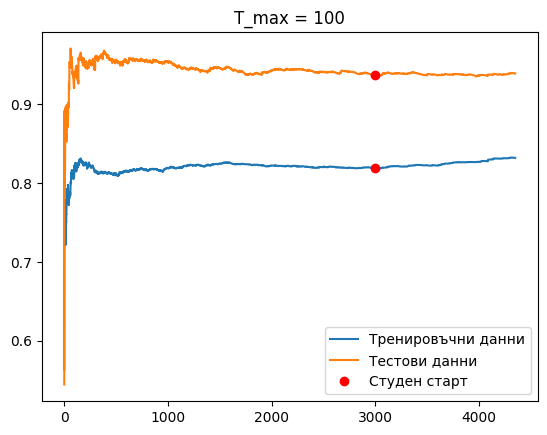

In [ ]:
loss_train,L_train = loss_rmse(l2Utrain,l2Vtrain,M_train)
loss_test,L_test = loss_rmse(l2Utrain,l2Vtrain,M_test)
print("RMSE върху тренировъчни данни :",loss_train)
print("RMSE върху тестови данни :",loss_test)
loss_train,_ = loss_rmse(l2Utrain[3000:],l2Vtrain,M_train[3000:,:])
loss_test,_ = loss_rmse(l2Utrain[3000:],l2Vtrain,M_test[3000:,:])
print("RMSE върху тренировъчни данни (U_i > 3000) :",loss_train)
print("RMSE върху тестови данни (U_i > 3000) :",loss_test)
plt.plot(L_train,label="Тренировъчни данни")
plt.plot(L_test,label="Тестови данни")
plt.plot([2999],[L_train[2999]],'o',color="red",label="Студен старт")
plt.plot([2999],[L_test[2999]],'o',color="red")
plt.title("T_max = 100")
plt.legend()
plt.show()

RMSE грешката изглежда сходна с тази от първия вариант

In [ ]:
print("Точност върху тренировъчни данни (Бандит) :",eval_accuracy(l2Utrain,l2Vtrain,M_train,seen_users_train))
print("Точност върху тестови данни (Бандит) :",eval_accuracy(l2Utrain,l2Vtrain,M_test,seen_users_test))
print("Точност върху тренировъчни данни (Бандит) (> 3000) :",eval_accuracy(l2Utrain[3000:],l2Vtrain,M_train[3000:],seen_users_train[3000:]))
print("Точност върху тестови данни (Бандит) (> 3000) :",eval_accuracy(l2Utrain[3000:],l2Vtrain,M_test[3000:],seen_users_test[3000:]))

Точност върху тренировъчни данни (Бандит) : 0.831303148701448
Точност върху тестови данни (Бандит) : 0.654102505171225
Точност върху тренировъчни данни (Бандит) (> 3000) : 0.9141376757957069
Точнсот върху тестови данни (Бандит) (> 3000) : 0.6476683937823834


Също така изглежда, че алгоритъма се научава да препоръча на потребитела най-предпочитан филм за тестовите данни с точност 65%